# Data Transformations before Modeling Process

Note: some of preliminary methodogy for merging datasets and cleaning to set up data for training/testing is taken from https://www.kaggle.com/code/raddar/vilnius-ncaa which is a submission from the Kaggle competition the code is taken from. We will be adding other external attributes (including Pomeroy rankings and Autodraft logic) and using a different modeling process

# Importing CSV files from Kaggle

In [198]:

import pandas as pd
import numpy as np
import seaborn as sns

In [199]:
regular_results = pd.read_csv("MRegularSeasonDetailedResults.csv")
tourney_results = pd.read_csv("MNCAATourneyDetailedResults.csv")
seeds = pd.read_csv("MNCAATourneySeeds.csv")
slots = pd.read_csv("MNCAATourneySlots.csv")
teams = pd.read_csv("MTeams.csv")

In [200]:
display(regular_results.head())

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [201]:
# Ensuring earliest year in datasets is 2003 (Consistent with Pomeroy Rankings)
print(min(regular_results["Season"].value_counts().index))
print(min(tourney_results["Season"].value_counts().index))
seeds = seeds.loc[seeds["Season"] >= 2003]
print(min(seeds["Season"].value_counts().index))

2003
2003
2003


In [202]:
regular_results[regular_results["Season"] == 2025].isna().sum().sort_index(ascending=False)

WTeamID    0
WTO        0
WStl       0
WScore     0
WPF        0
WOR        0
WLoc       0
WFTM       0
WFTA       0
WFGM3      0
WFGM       0
WFGA3      0
WFGA       0
WDR        0
WBlk       0
WAst       0
Season     0
NumOT      0
LTeamID    0
LTO        0
LStl       0
LScore     0
LPF        0
LOR        0
LFTM       0
LFTA       0
LFGM3      0
LFGM       0
LFGA3      0
LFGA       0
LDR        0
LBlk       0
LAst       0
DayNum     0
dtype: int64

In [203]:
# how many teams in each season
teams["TeamID"].nunique()

380

In [204]:
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,2024,146,1301,76,1181,64,N,0,28,60,...,20,21,26,10,27,11,9,4,5,23
1378,2024,146,1345,72,1397,66,N,0,24,53,...,26,7,11,6,17,17,6,8,4,25
1379,2024,152,1163,86,1104,72,N,0,31,62,...,23,9,11,7,21,9,7,2,5,15
1380,2024,152,1345,63,1301,50,N,0,22,55,...,19,3,4,6,22,10,11,8,3,13


For visualization purposes: can see how a team performs over the course of its regular season and its tournament for each season. 

In [205]:
# let's take one random team and see its journey during the 2024 season
season = 2025
teamid = 1104

# showing regular season going into the tournament and tournament data for the year
r = regular_results.loc[
    (regular_results["Season"] == season)
    & ((regular_results["WTeamID"] == teamid) | (regular_results["LTeamID"] == teamid))
]
t = tourney_results.loc[
    (tourney_results["Season"] == season)
    & ((tourney_results["WTeamID"] == teamid) | (tourney_results["LTeamID"] == teamid))
]
r["win"] = np.where(r["WTeamID"] == teamid, "win", "lose")
t["win"] = np.where(t["WTeamID"] == teamid, "win", "lose")
r["type"] = "regular season"
t["type"] = "tournament"

rt = pd.concat([r, t])
rt[["DayNum", "WScore", "LScore", "type", "win"]]

/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_78435/3446749376.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r["win"] = np.where(r["WTeamID"] == teamid, "win", "lose")
/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_78435/3446749376.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r["type"] = "regular season"


,DayNum,WScore,LScore,type,win
113241,0,110,54,regular season,win
113411,4,88,79,regular season,win
113547,7,72,64,regular season,win
113724,11,87,78,regular season,lose
113916,16,100,87,regular season,win
114219,22,85,80,regular season,win
114275,23,95,90,regular season,win
114447,26,83,81,regular season,lose
114563,30,94,79,regular season,win
114859,40,83,75,regular season,win


In [206]:
len(tourney_results[tourney_results["Season"] == 2023])
# 67 games in tournament 

67

In [207]:
len(seeds[seeds["Season"] == 2025])

68

In [208]:
# Looking into format of "seeds" table 
seeds.reset_index(drop=True, inplace=True)
s = seeds.loc[seeds["Season"] == 2025]
seed_list = [s.loc[s["Seed"].str.startswith(d)] for d in ("X", "Y", "Z", "W")]
# Note that X, Y, Z, W are the divisions and each will have its own seed. 


# Double the dataset with swapped team positions in box scores
- Avoid bias from putting team in T1 position (on left vs. right)
- Help model generalize rather than learn teams specific position

In [209]:
'''
# double the dataset with swapped team positions in box scores
def prepare_data(df):
    df = df[["Season", "DayNum", "LTeamID", "LScore", "WTeamID", "WScore", "NumOT",
            "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
            "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]]
    

    # adjustment factor for overtimes, as more stats are accumulated during overtimes
    adjot = (40 + 5 * df["NumOT"]) / 40
    # selecting which columns to adjust (not Season, DayNum, LTeamID, WTeamID))
    adjcols = ["LScore", "WScore", 
               "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
               "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]
    for col in adjcols:
        df[col] = df[col] / adjot    
    
    dfswap = df.copy()
    # Swapping team positions
    df.columns = [x.replace("W", "T1_").replace("L", "T2_") for x in list(df.columns)]
    dfswap.columns = [x.replace("L", "T1_").replace("W", "T2_") for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output["PointDiff"] = output["T1_Score"] - output["T2_Score"]
    # if positive point diff (assuming team 1 is the winner or loser we consider), then team 1 wins
    output["win"] = (output["PointDiff"] > 0) * 1
    # output["men_women"] = (output["T1_TeamID"].apply(lambda t: str(t).startswith("1"))) * 1  # 0: women, 1: men
    return output

regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)
'''

'\n# double the dataset with swapped team positions in box scores\ndef prepare_data(df):\n    df = df[["Season", "DayNum", "LTeamID", "LScore", "WTeamID", "WScore", "NumOT",\n            "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",\n            "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]]\n\n\n    # adjustment factor for overtimes, as more stats are accumulated during overtimes\n    adjot = (40 + 5 * df["NumOT"]) / 40\n    # selecting which columns to adjust (not Season, DayNum, LTeamID, WTeamID))\n    adjcols = ["LScore", "WScore", \n               "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",\n               "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]\n    for col in adjcols:\n        df[col] = df[col] / adjot    \n\n    dfswap = df.copy()\n    # Swapping tea

In [210]:
def prepare_data_regular(df):
    df = df[["Season", "DayNum", "LTeamID", "LScore", "WTeamID", "WScore", "NumOT",
            "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
            "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]]

    # OT adjustment factor
    adjot = (40 + 5 * df["NumOT"]) / 40
    adjcols = ["LScore", "WScore", 
               "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
               "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]
    for col in adjcols:
        df[col] = df[col] / adjot

    # Swap win/loss team columns to double dataset
    dfswap = df.copy()
    df.columns = [x.replace("W", "T1_").replace("L", "T2_") for x in df.columns]
    dfswap.columns = [x.replace("L", "T1_").replace("W", "T2_") for x in dfswap.columns]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output["PointDiff"] = output["T1_Score"] - output["T2_Score"]
    output["win"] = (output["PointDiff"] > 0).astype(int)
    return output
regular_data = prepare_data_regular(regular_results)


/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_78435/1021593081.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col] / adjot


Append 2025 tourney data (scraped from web) and pre 2025 tourney data

In [211]:
# Load pre-2025 and 2025 tournament results
tourney_pre2025 = tourney_results[[
    "Season", "DayNum", "WTeamID", "WScore", "LTeamID", "LScore"
]]
tourney_2025 = pd.read_csv("2025_Tourney_Results_Complete.csv")[[
    "Season", "DayNum", "WTeamID", "WScore", "LTeamID", "LScore"
]]

# Combine into one full tournament set
combined_tourney = pd.concat([tourney_pre2025, tourney_2025], ignore_index=True)

# Rename for winner = T1, loser = T2
combined_tourney = combined_tourney.rename(columns={
    "WTeamID": "T1_TeamID",
    "WScore": "T1_Score",
    "LTeamID": "T2_TeamID",
    "LScore": "T2_Score"
})

# Compute point diff and assign win = 1 (T1 won)
combined_tourney["PointDiff"] = combined_tourney["T1_Score"] - combined_tourney["T2_Score"]
combined_tourney["win"] = 1

# Now create the swapped version: T2 is T1, T1 is T2, and win = 0
swapped = combined_tourney.rename(columns={
    "T1_TeamID": "T2_TeamID",
    "T2_TeamID": "T1_TeamID",
    "T1_Score": "T2_Score",
    "T2_Score": "T1_Score"
})
swapped["PointDiff"] = swapped["T1_Score"] - swapped["T2_Score"]
swapped["win"] = 0

# Combine original + swapped for a balanced set
tourney_data = pd.concat([combined_tourney, swapped], ignore_index=True)

# Final column order (optional)
tourney_data = tourney_data[["Season", "T1_TeamID", "T2_TeamID", "T1_Score", "T2_Score", "PointDiff", "win"]]


In [212]:
display(regular_data.head())

,Season,DayNum,T2_TeamID,T2_Score,T1_TeamID,T1_Score,NumOT,T2_FGM,T2_FGA,T2_FGM3,...,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,PointDiff,win
0,2003,10,1328,62.0,1104,68.0,0,22.0,53.0,2.0,...,18.0,14.0,24.0,13.0,23.0,7.0,1.0,22.0,6.0,1
1,2003,10,1393,63.0,1272,70.0,0,24.0,67.0,6.0,...,19.0,15.0,28.0,16.0,13.0,4.0,4.0,18.0,7.0,1
2,2003,11,1437,61.0,1266,73.0,0,22.0,73.0,3.0,...,29.0,17.0,26.0,15.0,10.0,5.0,2.0,25.0,12.0,1
3,2003,11,1457,50.0,1296,56.0,0,18.0,49.0,6.0,...,31.0,6.0,19.0,11.0,12.0,14.0,2.0,18.0,6.0,1
4,2003,11,1208,71.0,1400,77.0,0,24.0,62.0,6.0,...,13.0,17.0,22.0,12.0,14.0,4.0,4.0,20.0,6.0,1


In [213]:
tourney_2025

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2025,139,1196,85,1436,62
1,2025,139,1222,77,1255,51
2,2025,139,1120,74,1159,70
3,2025,139,1242,66,1463,59
4,2025,140,1314,71,1233,58
...,...,...,...,...,...,...
59,2025,147,1250,74,1429,63
60,2025,136,1344,75,1472,63
61,2025,144,1206,66,1131,65
62,2025,149,1106,85,1358,84


# Want tourney data for **labels** to train on

In [214]:
massey_ordinals = pd.read_csv("PreTourneyMasseyOrdinals.csv")
# selecting only columns we want to merge in 
massey = massey_ordinals[["Season", "TeamID", "OrdinalRank"]].copy()
display(massey.head())
# we want to take the OrinalRank column and merge it with our tourney data (for each team T1 and T2 on its team id)
# means need to merge twice like shown above
massey.dtypes

,Season,TeamID,OrdinalRank
0,2003,1102,159
1,2003,1103,229
2,2003,1104,12
3,2003,1105,314
4,2003,1106,260


Season         int64
TeamID         int64
OrdinalRank    int64
dtype: object

In [215]:
# grabbing numeric part of seed and converting to int ( we still want to keep the division info)
seeds["seed"] = seeds["Seed"].apply(lambda x: int(x[1:3]))

seeds_T1 = seeds[["Season", "TeamID", "seed"]].copy()
seeds_T2 = seeds[["Season", "TeamID", "seed"]].copy()
seeds_T1.columns = ["Season", "T1_TeamID", "T1_seed"]
seeds_T2.columns = ["Season", "T2_TeamID", "T2_seed"]

# merging seeds (for each team) with tourney data
tourney_data = tourney_data[["Season", "T1_TeamID", "T2_TeamID", "PointDiff", "win",]]
tourney_data = pd.merge(tourney_data, seeds_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, seeds_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data["Seed_diff"] = tourney_data["T2_seed"] - tourney_data["T1_seed"]
# dont need individual seeds for each team if have difference
tourney_data = tourney_data[["Season", "T1_TeamID", "T2_TeamID", "PointDiff", "win", "Seed_diff"]]
display(tourney_data)

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff
0,2003,1421,1411,8,1,0.0
1,2003,1112,1436,29,1,15.0
2,2003,1113,1272,13,1,-3.0
3,2003,1141,1166,6,1,-5.0
4,2003,1143,1301,2,1,1.0
...,...,...,...,...,...,...
2887,2025,1429,1250,-11,0,NaN
2888,2025,1472,1344,-12,0,NaN
2889,2025,1131,1206,-1,0,NaN
2890,2025,1358,1106,-1,0,NaN


<Axes: xlabel='Seed_diff', ylabel='PointDiff'>

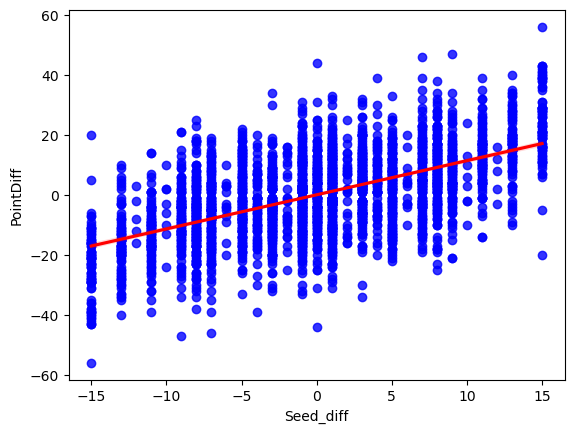

In [216]:
# seed difference vs point difference (between Team 1 and Team 2)
sns.regplot(x=tourney_data["Seed_diff"], y=tourney_data["PointDiff"], color='blue', line_kws={"color": "red"})

# Aggregating Game Stats: Offensive/Defensive for *Each T1 and T2*

In [217]:
# From MRegularSeasonDetailedResults and some of ourcalculations (point diff)
# box score columns, for which we want features to our model
boxcols = [
    "T1_Score", "T1_FGM", "T1_FGA", "T1_FGM3", "T1_FGA3", "T1_FTM", "T1_FTA",
    "T1_OR", "T1_DR", "T1_Ast", "T1_TO", "T1_Stl", "T1_Blk", "T1_PF",
    "T2_Score", "T2_FGM", "T2_FGA", "T2_FGM3", "T2_FGA3", "T2_FTM", "T2_FTA",
    "T2_OR", "T2_DR", "T2_Ast", "T2_TO", "T2_Stl", "T2_Blk", "T2_PF",
    "PointDiff",
]

# Regular season is **attributes** we train on

In [218]:
# calculate season averages for each team 
# for each team, we take the mean of the box score columns (for each unique instance of team T1 and year)
ss = regular_data.groupby(["Season", "T1_TeamID"])[boxcols].agg("mean").reset_index()

ss_T1 = ss.copy()
ss_T1.columns = ["T1_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T1.columns)]
ss_T1 = ss_T1.rename({"T1_avg_Season": "Season", "T1_avg_TeamID": "T1_TeamID"}, axis=1)
ss_T2 = ss.copy()
ss_T2.columns = ["T2_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T2.columns)]
ss_T2 = ss_T2.rename({"T2_avg_Season": "Season", "T2_avg_TeamID": "T2_TeamID"}, axis=1)

# merging season averages with tourney data
tourney_data = pd.merge(tourney_data, ss_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, ss_T2, on=["Season", "T2_TeamID"], how="left")
display(tourney_data.head())

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T2_avg_opponent_FTM,T2_avg_opponent_FTA,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff
0,2003,1421,1411,8,1,0.0,69.615326,23.847510,55.639847,6.348659,...,11.914815,18.655556,11.881481,22.781481,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148
1,2003,1112,1436,29,1,15.0,84.511905,30.067460,65.087302,6.984127,...,10.331034,15.482759,9.517241,21.641379,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655
2,2003,1113,1272,13,1,-3.0,75.344828,27.003831,56.436782,3.977011,...,13.333333,20.659004,12.295019,23.482759,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487
3,2003,1141,1166,6,1,-5.0,79.344828,26.620690,52.689655,6.827586,...,11.643098,16.619529,11.020202,21.289562,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990
4,2003,1143,1301,2,1,1.0,73.636015,27.015326,57.946360,6.314176,...,15.374074,21.129630,10.514815,21.348148,12.511111,14.581481,7.418519,2.811111,19.262963,4.370370


In [219]:
tourney_data.columns

Index(['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff', 'win', 'Seed_diff',
       'T1_avg_Score', 'T1_avg_FGM', 'T1_avg_FGA', 'T1_avg_FGM3',
       'T1_avg_FGA3', 'T1_avg_FTM', 'T1_avg_FTA', 'T1_avg_OR', 'T1_avg_DR',
       'T1_avg_Ast', 'T1_avg_TO', 'T1_avg_Stl', 'T1_avg_Blk', 'T1_avg_PF',
       'T1_avg_opponent_Score', 'T1_avg_opponent_FGM', 'T1_avg_opponent_FGA',
       'T1_avg_opponent_FGM3', 'T1_avg_opponent_FGA3', 'T1_avg_opponent_FTM',
       'T1_avg_opponent_FTA', 'T1_avg_opponent_OR', 'T1_avg_opponent_DR',
       'T1_avg_opponent_Ast', 'T1_avg_opponent_TO', 'T1_avg_opponent_Stl',
       'T1_avg_opponent_Blk', 'T1_avg_opponent_PF', 'T1_avg_PointDiff',
       'T2_avg_Score', 'T2_avg_FGM', 'T2_avg_FGA', 'T2_avg_FGM3',
       'T2_avg_FGA3', 'T2_avg_FTM', 'T2_avg_FTA', 'T2_avg_OR', 'T2_avg_DR',
       'T2_avg_Ast', 'T2_avg_TO', 'T2_avg_Stl', 'T2_avg_Blk', 'T2_avg_PF',
       'T2_avg_opponent_Score', 'T2_avg_opponent_FGM', 'T2_avg_opponent_FGA',
       'T2_avg_opponent_FGM3', 'T2_

Basically, tourney schedule is deciding WHICH matchups we use in training set (and who won!), seeds, and point differences.
For each team in the match up, we are going to include its season averages in play statistics IN this row. This way, we are training on during-season data to see if we can predict tournament matchup results (our bracket)

# Questions: 
- Should we be subtracting or taking ratios between T1 and T2 stats so we can get relative stats? 
- Do we want ALL of these during game stats or do we just want certain ones? We can start with all and use some systematic feature selection because we don't have too much field knowledge

Note: to add: massey ordinals rankings (diff?), pomeroy ratings (diff?), conference 

Need to choose ranking or few from all possible Massey Ranking Systems

In [220]:
pre_tourney_massey = pd.read_csv("Massey_AllYears.csv")
# selecting only columns we want to merge in 
#massey = massey_ordinals[["Season", "TeamID", "OrdinalRank"]].copy()
#display(massey_ordinals.head())
# we want to take the OrinalRank column and merge it with our tourney data (for each team T1 and T2 on its team id)
# means need to merge twice like shown above
#pre_tourney_massey = massey_ordinals[massey_ordinals["RankingDayNum"] == 133]
display(pre_tourney_massey.head())
pre_tourney_massey["SystemName"].value_counts()
# would only choose ranking system where we have all teams pre tournament (day 133) rankings for each year
# or at least as many as possible (dont mind cutting a few teams that wouldn't be ranked and therefore not in the tournament)

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,133,AP,1112,2
1,2003,133,AP,1163,23
2,2003,133,AP,1166,15
3,2003,133,AP,1173,16
4,2003,133,AP,1181,7


SystemName
MOR    7263
POM    7260
WLK    7260
DOL    7259
COL    7258
       ... 
REI     326
RM      326
JON     326
D1A     200
TRX     120
Name: count, Length: 180, dtype: int64

From source: https://kenpom.com (also includes meaning for each field)

Compared to our original 80 teams:

In [221]:
# Group by 'systemName' and count distinct teams in 'TeamID' (or the relevant column for teams)
distinct_teams_per_system = pre_tourney_massey.groupby('SystemName')['TeamID'].nunique().sort_values(ascending=False)

print(distinct_teams_per_system[distinct_teams_per_system == 369])

# comparing to abbreviation mappings on Massey site:
# can't find DOL, DUN, SEL, WLK, POM
# Use RPI, COL (Colley), MOR (Moore), BIH (Bihl), MAS bc have mappings to name/meaning
# already have pomeroy 

# creating least amount of missing values after merges/joins by selecting the system with most teams
# less imputation or dropped values needed. generating complete-case training instances 


SystemName
DOL    369
DUN    369
RPI    369
COL    369
SEL    369
MOR    369
BIH    369
POM    369
MAS    369
WLK    369
Name: TeamID, dtype: int64


In [222]:
# Filtering for only these ranking systems 
# "RPI", "MOR", "COL", "BIH", "MAS"
pre_tourney_massey = pre_tourney_massey.loc[(pre_tourney_massey["SystemName"] == "RPI") | (pre_tourney_massey["SystemName"] == "MOR") | (pre_tourney_massey["SystemName"] == "COL") | (pre_tourney_massey["SystemName"] == "BIH") | (pre_tourney_massey["SystemName"] == "MAS")]
pre_tourney_massey = pre_tourney_massey.drop(columns=["RankingDayNum"])
display(pre_tourney_massey.head())

# Now that we only have 5 ranking systems, convert system name to columns 
# pivot the data to have systemName as columns
pivoted_massey = pre_tourney_massey.pivot(index=['TeamID', 'Season'], columns='SystemName', values='OrdinalRank').reset_index()

print(pivoted_massey)


,Season,SystemName,TeamID,OrdinalRank
352,2003,BIH,1102,172
353,2003,BIH,1103,177
354,2003,BIH,1104,40
355,2003,BIH,1105,312
356,2003,BIH,1106,269


SystemName  TeamID  Season    BIH    COL    MAS    MOR    RPI
0             1101    2014  346.0  340.0  349.0  349.0    NaN
1             1101    2015  325.0  322.0  331.0  346.0  325.0
2             1101    2016  309.0  304.0  312.0  311.0  321.0
3             1101    2017  285.0  287.0  292.0  317.0  289.0
4             1101    2018  260.0  267.0  259.0  265.0  260.0
...            ...     ...    ...    ...    ...    ...    ...
7258          1476    2023  312.0  301.0  327.0  327.0  263.0
7259          1476    2024  358.0  360.0  359.0  356.0  360.0
7260          1477    2023  311.0  315.0  326.0  308.0  308.0
7261          1477    2024  318.0  312.0  325.0  331.0  310.0
7262          1478    2024  311.0  316.0  322.0  281.0  303.0

[7263 rows x 7 columns]


Exported 2025 Pre Tournament Massey Ordinals From https://masseyratings.com/ranks?s=cb&d=20250316 because had no Massey data for 2025

In [223]:
massey_2025 = pd.read_csv("Massey_PreSeason2025.csv")
massey_2025 = massey_2025.dropna()
massey_2025["Season"] = massey_2025["Season"].astype(int)
# join team name on team id
massey_2025 = massey_2025.merge(
    teams[["TeamID", "TeamName"]],
    how='left', 
    left_on=['Team'],
    right_on=['TeamName']
).drop(columns=['Team'])
# no team names that didnt match 
nan_count_col1 = massey_2025['TeamID'].isna().sum()
print(nan_count_col1)
display(massey_2025.head())

0


,RPI,BIH,COL,MAS,MOR,Season,TeamID,TeamName
0,4.0,3.0,4.0,2.0,1.0,2025,1181,Duke
1,1.0,1.0,1.0,4.0,4.0,2025,1120,Auburn
2,3.0,2.0,2.0,3.0,2.0,2025,1196,Florida
3,6.0,4.0,3.0,1.0,3.0,2025,1222,Houston
4,2.0,6.0,5.0,5.0,5.0,2025,1104,Alabama


In [224]:
massey_2025 = massey_2025[["TeamID", "Season", "BIH", "COL", "MAS", "MOR", "RPI"]]
# Combine into one full massey set
combined_massey = pd.concat([pivoted_massey, massey_2025], ignore_index=True)
#combined_massey["Season"].value_counts()
display(combined_massey.head())

,TeamID,Season,BIH,COL,MAS,MOR,RPI
0,1101,2014,346.0,340.0,349.0,349.0,NaN
1,1101,2015,325.0,322.0,331.0,346.0,325.0
2,1101,2016,309.0,304.0,312.0,311.0,321.0
3,1101,2017,285.0,287.0,292.0,317.0,289.0
4,1101,2018,260.0,267.0,259.0,265.0,260.0


In [225]:
#test = pd.merge(tourney_data, massey, left_on=["Season", "T2_TeamID"], right_on=["Season", "TeamID"], how="left")

In [226]:
# We will be combining in this data from Pomeroy rankings (external source)
pomeroy = pd.read_csv("KenPom Stats.csv")
pomeroy = pomeroy.dropna()
pomeroy = pomeroy.drop(columns=[col for col in pomeroy.columns if "_rank" in col])
pomeroy["YEAR"] = pomeroy["YEAR"].astype(int)
# remove periods from team name column 
pomeroy['Team'] = pomeroy['Team'].str.replace('.', '', regex=False)
dat= pd.merge(pomeroy, teams[["TeamID", "TeamName"]], how='inner',left_on="Team", right_on="TeamName")
dat = dat.drop(columns=dat.columns[-1])

print(pomeroy["Team"].nunique())
print(dat["Team"].nunique())
display(dat)

# for this file we can use the ranking for each stat (its built in) and maybe use some differences
# because we also have the raw value for these statistics, idk which we would want

# mapping to this table's year and Team id (team id to team name table)

/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_78435/1074537758.py:2: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  pomeroy = pd.read_csv("KenPom Stats.csv")


395
290


,Rk,Team,Conf,W_L,NetRtg,ORtg,DRtg,AdjT,Luck,SchedStrengthNetRtg,SchedStrengthORtg,SchedStrengthDRtg,NCSOSNetRtg,YEAR,TeamID
0,1.0,Kentucky,SEC,32-4,29.18,116.5,87.4,67.7,0.051,11.20,108.6,97.4,6.77,2003,1246
1,2.0,Kansas,B12,30-8,28.62,115.0,86.4,72.2,-0.017,11.84,108.6,96.8,6.07,2003,1242
2,3.0,Pittsburgh,BE,28-5,28.61,114.8,86.2,64.7,-0.023,7.08,105.5,98.4,-8.24,2003,1338
3,4.0,Arizona,P10,28-4,26.80,115.6,88.8,72.7,-0.007,8.69,107.2,98.5,8.19,2003,1112
4,5.0,Illinois,B10,25-7,24.47,113.2,88.7,67.8,-0.029,7.29,105.8,98.5,-4.18,2003,1228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6217,356.0,New Hampshire,AE,24-Aug,-21.72,93.9,115.6,67.6,0.019,-6.16,103.7,109.9,-3.50,2025,1306
6218,359.0,Canisius,MAAC,28-Mar,-23.01,99.1,122.1,66.4,-0.078,-4.88,103.0,107.9,3.86,2025,1145
6219,360.0,Alabama A&M,SWAC,22-Oct,-23.36,92.2,115.6,71.2,-0.022,-9.57,101.3,110.8,1.93,2025,1105
6220,361.0,Coppin St,MEAC,24-Jun,-24.40,87.4,111.8,68.0,0.033,-4.43,105.3,109.8,4.14,2025,1164


In [227]:
pomeroy[pomeroy["YEAR"] == 2025].isna().sum().sort_index(ascending=False)

YEAR                   0
W_L                    0
Team                   0
SchedStrengthORtg      0
SchedStrengthNetRtg    0
SchedStrengthDRtg      0
Rk                     0
ORtg                   0
NetRtg                 0
NCSOSNetRtg            0
Luck                   0
DRtg                   0
Conf                   0
AdjT                   0
dtype: int64

Note that with using pomeroy data we are gonna be reducing the number of teams, but these teams not considered likely won't be tournament games we care about. We can make that call

To do list

In [228]:
# add in the massey ordinals - NEED TO CHOOSE SYSTEM
# add in pomeroy rankings (delete all columns with rank because are showing what rank that team would be in terms of that stat)
# take all differences T1 - T2 for each stat
# can keep the point differences and win/loss columns (we can decide later when fitting models if we want numeric or binary label)
# export to csv 
# bring into weka - start looking at correlations of our final dataset 

In [229]:
# Merge pomeroy ORtg and DRtg for T1
tourney_data = tourney_data.merge(
    dat[['TeamID', 'YEAR', 'ORtg', 'DRtg', 'SchedStrengthNetRtg', 'NCSOSNetRtg', 'AdjT', 'Luck']],
    how='left', 
    left_on=['T1_TeamID', 'Season'],
    right_on=['TeamID', 'YEAR']
).rename(columns={
    'ORtg': 'T1_ORtg',
    'DRtg': 'T1_Drtg',
    'SchedStrengthNetRtg': 'T1_SchedStrengthNetRtg',
    'NCSOSNetRtg': 'T1_NCSOSNetRtg',
    'AdjT': 'T1_AdjT',
    'Luck': 'T1_Luck'
}).drop(columns=['TeamID', 'YEAR'])

tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_ORtg,T1_Drtg,T1_SchedStrengthNetRtg,T1_NCSOSNetRtg,T1_AdjT,T1_Luck
0,2003,1421,1411,8,1,0.0,69.615326,23.847510,55.639847,6.348659,...,7.977778,2.596296,21.533333,1.948148,101.2,113.5,-6.45,11.61,68.0,0.119
1,2003,1112,1436,29,1,15.0,84.511905,30.067460,65.087302,6.984127,...,7.082759,3.655172,17.772414,4.689655,115.6,88.8,8.69,8.19,72.7,-0.007
2,2003,1113,1272,13,1,-3.0,75.344828,27.003831,56.436782,3.977011,...,7.252874,3.153257,19.827586,8.693487,113.9,97.4,8.74,5.43,66.9,-0.014
3,2003,1141,1166,6,1,-5.0,79.344828,26.620690,52.689655,6.827586,...,6.306397,2.569024,19.323232,14.898990,NaN,NaN,NaN,NaN,NaN,NaN
4,2003,1143,1301,2,1,1.0,73.636015,27.015326,57.946360,6.314176,...,7.418519,2.811111,19.262963,4.370370,109.9,96.3,7.06,0.30,65.9,0.061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2025,1429,1250,-11,0,NaN,79.750000,27.906250,57.625000,8.718750,...,6.123016,2.865079,16.757937,-3.567460,119.8,105.8,6.12,0.68,67.6,0.092
2888,2025,1472,1344,-12,0,NaN,81.297491,27.967742,57.225806,10.261649,...,7.295139,2.892361,14.927083,-1.180556,NaN,NaN,NaN,NaN,NaN,NaN
2889,2025,1131,1206,-1,0,NaN,64.453763,23.089606,53.434409,7.373477,...,7.152862,3.311111,18.340741,6.449158,NaN,NaN,NaN,NaN,NaN,NaN
2890,2025,1358,1106,-1,0,NaN,72.118774,24.501916,56.076628,8.272031,...,5.228956,3.265993,16.057239,-0.336700,110.4,111.5,4.06,7.22,67.8,-0.040


In [230]:
#tourney_data = tourney_data.iloc[:, :-8]
tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_ORtg,T1_Drtg,T1_SchedStrengthNetRtg,T1_NCSOSNetRtg,T1_AdjT,T1_Luck
0,2003,1421,1411,8,1,0.0,69.615326,23.847510,55.639847,6.348659,...,7.977778,2.596296,21.533333,1.948148,101.2,113.5,-6.45,11.61,68.0,0.119
1,2003,1112,1436,29,1,15.0,84.511905,30.067460,65.087302,6.984127,...,7.082759,3.655172,17.772414,4.689655,115.6,88.8,8.69,8.19,72.7,-0.007
2,2003,1113,1272,13,1,-3.0,75.344828,27.003831,56.436782,3.977011,...,7.252874,3.153257,19.827586,8.693487,113.9,97.4,8.74,5.43,66.9,-0.014
3,2003,1141,1166,6,1,-5.0,79.344828,26.620690,52.689655,6.827586,...,6.306397,2.569024,19.323232,14.898990,NaN,NaN,NaN,NaN,NaN,NaN
4,2003,1143,1301,2,1,1.0,73.636015,27.015326,57.946360,6.314176,...,7.418519,2.811111,19.262963,4.370370,109.9,96.3,7.06,0.30,65.9,0.061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2025,1429,1250,-11,0,NaN,79.750000,27.906250,57.625000,8.718750,...,6.123016,2.865079,16.757937,-3.567460,119.8,105.8,6.12,0.68,67.6,0.092
2888,2025,1472,1344,-12,0,NaN,81.297491,27.967742,57.225806,10.261649,...,7.295139,2.892361,14.927083,-1.180556,NaN,NaN,NaN,NaN,NaN,NaN
2889,2025,1131,1206,-1,0,NaN,64.453763,23.089606,53.434409,7.373477,...,7.152862,3.311111,18.340741,6.449158,NaN,NaN,NaN,NaN,NaN,NaN
2890,2025,1358,1106,-1,0,NaN,72.118774,24.501916,56.076628,8.272031,...,5.228956,3.265993,16.057239,-0.336700,110.4,111.5,4.06,7.22,67.8,-0.040


In [231]:
# Merge pomeroy ORtg and DRtg for T2
tourney_data = tourney_data.merge(
    dat[['TeamID', 'YEAR', 'ORtg', 'DRtg', 'SchedStrengthNetRtg', 'NCSOSNetRtg', 'AdjT', 'Luck']],
    how='left', 
    left_on=['T2_TeamID', 'Season'],
    right_on=['TeamID', 'YEAR']
).rename(columns={
    'ORtg': 'T2_ORtg',
    'DRtg': 'T2_Drtg',
    'SchedStrengthNetRtg': 'T2_SchedStrengthNetRtg',
    'NCSOSNetRtg': 'T2_NCSOSNetRtg',
    'AdjT': 'T2_AdjT',
    'Luck': 'T2_Luck'
}).drop(columns=['TeamID', 'YEAR'])

tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T1_SchedStrengthNetRtg,T1_NCSOSNetRtg,T1_AdjT,T1_Luck,T2_ORtg,T2_Drtg,T2_SchedStrengthNetRtg,T2_NCSOSNetRtg,T2_AdjT,T2_Luck
0,2003,1421,1411,8,1,0.0,69.615326,23.847510,55.639847,6.348659,...,-6.45,11.61,68.0,0.119,NaN,NaN,NaN,NaN,NaN,NaN
1,2003,1112,1436,29,1,15.0,84.511905,30.067460,65.087302,6.984127,...,8.69,8.19,72.7,-0.007,101.1,99.5,-5.14,-2.29,64.4,0.019
2,2003,1113,1272,13,1,-3.0,75.344828,27.003831,56.436782,3.977011,...,8.74,5.43,66.9,-0.014,110.9,94.1,4.83,3.33,68.3,0.005
3,2003,1141,1166,6,1,-5.0,79.344828,26.620690,52.689655,6.827586,...,NaN,NaN,NaN,NaN,112.4,94.9,-0.19,-0.51,68.4,0.026
4,2003,1143,1301,2,1,1.0,73.636015,27.015326,57.946360,6.314176,...,7.06,0.30,65.9,0.061,111.2,98.1,8.48,-6.48,65.0,-0.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2025,1429,1250,-11,0,NaN,79.750000,27.906250,57.625000,8.718750,...,6.12,0.68,67.6,0.092,100.7,111.0,-6.36,3.24,67.5,-0.097
2888,2025,1472,1344,-12,0,NaN,81.297491,27.967742,57.225806,10.261649,...,NaN,NaN,NaN,NaN,112.1,105.2,9.71,-0.64,66.5,-0.097
2889,2025,1131,1206,-1,0,NaN,64.453763,23.089606,53.434409,7.373477,...,NaN,NaN,NaN,NaN,106.2,96.8,0.70,-5.46,64.9,0.063
2890,2025,1358,1106,-1,0,NaN,72.118774,24.501916,56.076628,8.272031,...,4.06,7.22,67.8,-0.040,101.5,110.4,-7.93,6.06,68.1,0.060


In [232]:
# Merge massey ordinals for T1 (using selected 3 ranking systems explained above)
tourney_data = tourney_data.merge(
    combined_massey[['TeamID', 'Season', "RPI", "MOR", "COL", "BIH", "MAS"]],
    how='left', 
    left_on=['T1_TeamID', 'Season'],
    right_on=['TeamID', 'Season']
).rename(columns={
    'RPI': 'T1_RPI',
    'MOR': 'T1_MOR',
    'COL': 'T1_COL',
    'BIH': 'T1_BIH',
    'MAS': 'T1_MAS'
}).drop(columns=['TeamID'])
tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T2_Drtg,T2_SchedStrengthNetRtg,T2_NCSOSNetRtg,T2_AdjT,T2_Luck,T1_RPI,T1_MOR,T1_COL,T1_BIH,T1_MAS
0,2003,1421,1411,8,1,0.0,69.615326,23.847510,55.639847,6.348659,...,NaN,NaN,NaN,NaN,NaN,186.0,277.0,213.0,247.0,265.0
1,2003,1112,1436,29,1,15.0,84.511905,30.067460,65.087302,6.984127,...,99.5,-5.14,-2.29,64.4,0.019,2.0,4.0,2.0,2.0,3.0
2,2003,1113,1272,13,1,-3.0,75.344828,27.003831,56.436782,3.977011,...,94.1,4.83,3.33,68.3,0.005,32.0,22.0,38.0,43.0,40.0
3,2003,1141,1166,6,1,-5.0,79.344828,26.620690,52.689655,6.827586,...,94.9,-0.19,-0.51,68.4,0.026,44.0,50.0,35.0,38.0,36.0
4,2003,1143,1301,2,1,1.0,73.636015,27.015326,57.946360,6.314176,...,98.1,8.48,-6.48,65.0,-0.023,33.0,43.0,28.0,26.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2025,1429,1250,-11,0,NaN,79.750000,27.906250,57.625000,8.718750,...,111.0,-6.36,3.24,67.5,-0.097,29.0,50.0,30.0,32.0,38.0
2888,2025,1472,1344,-12,0,NaN,81.297491,27.967742,57.225806,10.261649,...,105.2,9.71,-0.64,66.5,-0.097,112.0,169.0,135.0,124.0,143.0
2889,2025,1131,1206,-1,0,NaN,64.453763,23.089606,53.434409,7.373477,...,96.8,0.70,-5.46,64.9,0.063,266.0,293.0,267.0,275.0,294.0
2890,2025,1358,1106,-1,0,NaN,72.118774,24.501916,56.076628,8.272031,...,110.4,-7.93,6.06,68.1,0.060,208.0,231.0,219.0,211.0,193.0


In [233]:
# Merge massey ordinals for T1 (using selected 5 ranking systems explained above)
tourney_data = tourney_data.merge(
    combined_massey[['TeamID', 'Season', "RPI", "MOR", "COL", "BIH", "MAS"]],
    how='left', 
    left_on=['T2_TeamID', 'Season'],
    right_on=['TeamID', 'Season']
).rename(columns={
    'RPI': 'T2_RPI',
    'MOR': 'T2_MOR',
    'COL': 'T2_COL',
    'BIH': 'T2_BIH',
    'MAS': 'T2_MAS'
}).drop(columns=['TeamID'])
tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T1_RPI,T1_MOR,T1_COL,T1_BIH,T1_MAS,T2_RPI,T2_MOR,T2_COL,T2_BIH,T2_MAS
0,2003,1421,1411,8,1,0.0,69.615326,23.847510,55.639847,6.348659,...,186.0,277.0,213.0,247.0,265.0,217.0,293.0,212.0,234.0,249.0
1,2003,1112,1436,29,1,15.0,84.511905,30.067460,65.087302,6.984127,...,2.0,4.0,2.0,2.0,3.0,144.0,187.0,144.0,151.0,148.0
2,2003,1113,1272,13,1,-3.0,75.344828,27.003831,56.436782,3.977011,...,32.0,22.0,38.0,43.0,40.0,26.0,23.0,19.0,19.0,18.0
3,2003,1141,1166,6,1,-5.0,79.344828,26.620690,52.689655,6.827586,...,44.0,50.0,35.0,38.0,36.0,23.0,33.0,18.0,17.0,19.0
4,2003,1143,1301,2,1,1.0,73.636015,27.015326,57.946360,6.314176,...,33.0,43.0,28.0,26.0,30.0,53.0,31.0,56.0,49.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2025,1429,1250,-11,0,NaN,79.750000,27.906250,57.625000,8.718750,...,29.0,50.0,30.0,32.0,38.0,304.0,289.0,318.0,315.0,324.0
2888,2025,1472,1344,-12,0,NaN,81.297491,27.967742,57.225806,10.261649,...,112.0,169.0,135.0,124.0,143.0,196.0,96.0,171.0,150.0,97.0
2889,2025,1131,1206,-1,0,NaN,64.453763,23.089606,53.434409,7.373477,...,266.0,293.0,267.0,275.0,294.0,30.0,74.0,46.0,58.0,72.0
2890,2025,1358,1106,-1,0,NaN,72.118774,24.501916,56.076628,8.272031,...,208.0,231.0,219.0,211.0,193.0,232.0,253.0,231.0,249.0,278.0


Do subtractions between T1 and T2 numeric columns (so we are training models on the difference)

In [234]:
# Identify all T1_ and T2_ columns
t1_columns = [col for col in tourney_data.columns if col.startswith('T1_') and col != 'T1_TeamID']
t2_columns = [col for col in tourney_data.columns if col.startswith('T2_') and col != 'T2_TeamID']

# Ensure matching columns between T1_ and T2_
common_columns = set(col[3:] for col in t1_columns).intersection(col[3:] for col in t2_columns)

# Subtract T2_ columns from T1_ columns
for col in common_columns:
    tourney_data[f'Diff_{col}'] = tourney_data[f'T1_{col}'] - tourney_data[f'T2_{col}']

tourney_data.drop(columns=t1_columns + t2_columns, inplace=True)

# Final dataset after transformations

In [235]:
display(tourney_data.head())

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,Diff_AdjT,Diff_Luck,Diff_avg_opponent_FGA,Diff_MOR,...,Diff_avg_TO,Diff_avg_FGM3,Diff_avg_opponent_DR,Diff_avg_OR,Diff_avg_PF,Diff_avg_DR,Diff_avg_opponent_Score,Diff_avg_PointDiff,Diff_Drtg,Diff_MAS
0,2003,1421,1411,8,1,0.0,NaN,NaN,-0.428097,-16.0,...,0.764368,0.437548,-0.379949,-1.092209,0.558238,-2.024904,6.362708,-9.280715,NaN,16.0
1,2003,1112,1436,29,1,15.0,8.3,-0.026,9.410591,-183.0,...,0.673563,1.742748,1.426081,2.148139,1.883853,1.874959,6.966229,10.290504,-10.7,-145.0
2,2003,1113,1272,13,1,-3.0,-1.4,-0.019,-2.417625,-1.0,...,0.141762,-2.992337,-3.114943,-0.517241,0.567050,-2.735632,3.057471,-1.923372,3.3,22.0
3,2003,1141,1166,6,1,-5.0,NaN,NaN,2.782886,17.0,...,4.931615,-1.115175,-2.393011,-0.262278,3.760130,0.178219,9.133635,-8.795542,NaN,17.0
4,2003,1143,1301,2,1,1.0,0.9,0.084,5.189017,12.0,...,-0.110473,-1.626564,1.310856,1.414943,-1.714815,2.188378,1.171520,0.342273,-1.8,-18.0


In [236]:
tourney_data.columns

Index(['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff', 'win', 'Seed_diff',
       'Diff_AdjT', 'Diff_Luck', 'Diff_avg_opponent_FGA', 'Diff_MOR',
       'Diff_avg_opponent_FGM3', 'Diff_ORtg', 'Diff_COL', 'Diff_avg_Stl',
       'Diff_avg_FGA3', 'Diff_avg_FGA', 'Diff_avg_Score',
       'Diff_avg_opponent_FGM', 'Diff_avg_opponent_Blk',
       'Diff_avg_opponent_Ast', 'Diff_avg_opponent_PF', 'Diff_avg_FTA',
       'Diff_avg_opponent_FGA3', 'Diff_avg_opponent_FTA',
       'Diff_avg_opponent_FTM', 'Diff_BIH', 'Diff_SchedStrengthNetRtg',
       'Diff_avg_Ast', 'Diff_avg_opponent_Stl', 'Diff_avg_Blk', 'Diff_avg_FGM',
       'Diff_avg_opponent_OR', 'Diff_RPI', 'Diff_NCSOSNetRtg',
       'Diff_avg_opponent_TO', 'Diff_avg_FTM', 'Diff_avg_TO', 'Diff_avg_FGM3',
       'Diff_avg_opponent_DR', 'Diff_avg_OR', 'Diff_avg_PF', 'Diff_avg_DR',
       'Diff_avg_opponent_Score', 'Diff_avg_PointDiff', 'Diff_Drtg',
       'Diff_MAS'],
      dtype='object')

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = tourney_data.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

# Unstack the correlation matrix to get pairs of attributes
correlation_pairs = corr_matrix.unstack()

# Remove self-correlations (correlation of a variable with itself)
correlation_pairs = correlation_pairs[correlation_pairs.index.get_level_values(0) != correlation_pairs.index.get_level_values(1)]

# Sort the correlation pairs by absolute value in descending order
sorted_correlations = correlation_pairs.abs().sort_values(ascending=False)

# Display the top N most highly correlated pairs
top_n = 10  # Change this to the number of pairs you want to see
print(sorted_correlations.head(top_n))

Diff_COL               Diff_BIH                 0.992632
Diff_BIH               Diff_COL                 0.992632
Diff_COL               Diff_RPI                 0.980453
Diff_RPI               Diff_COL                 0.980453
Diff_MAS               Diff_BIH                 0.977387
Diff_BIH               Diff_MAS                 0.977387
Diff_avg_opponent_FTA  Diff_avg_opponent_FTM    0.977200
Diff_avg_opponent_FTM  Diff_avg_opponent_FTA    0.977200
Diff_RPI               Diff_BIH                 0.971328
Diff_BIH               Diff_RPI                 0.971328
dtype: float64


From looking at top 10 correlations, we can see that the Massey ranking systems strongly agree with one another (6 of top 10 most strongly correlated pairs)

(array([14., 12.,  6.,  4.,  4.,  6.,  8.,  8.,  6.,  8.,  8., 10., 12.,
         6., 14., 10.,  6.,  0.,  6.,  0.,  2.,  0., 10.,  8.,  2.,  8.,
         6.,  4.,  4.,  8.]),
 array([0.50619389, 0.52240848, 0.53862308, 0.55483767, 0.57105226,
        0.58726686, 0.60348145, 0.61969604, 0.63591064, 0.65212523,
        0.66833982, 0.68455441, 0.70076901, 0.7169836 , 0.73319819,
        0.74941279, 0.76562738, 0.78184197, 0.79805656, 0.81427116,
        0.83048575, 0.84670034, 0.86291494, 0.87912953, 0.89534412,
        0.91155872, 0.92777331, 0.9439879 , 0.96020249, 0.97641709,
        0.99263168]),
 <BarContainer object of 30 artists>)

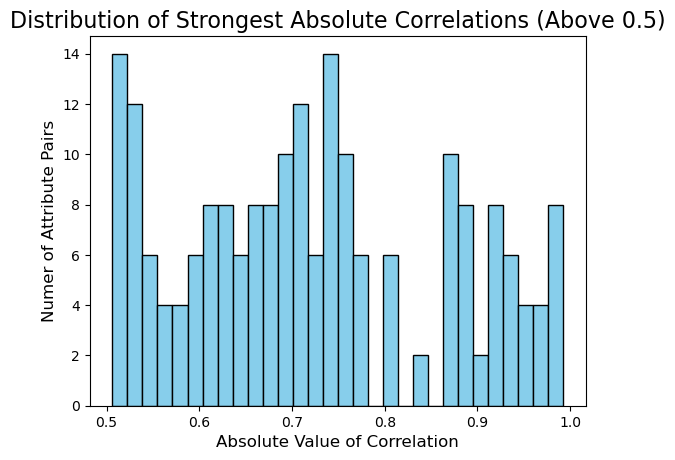

In [238]:
plt.title("Distribution of Strongest Absolute Correlations (Above 0.5)", fontsize=16)
plt.xlabel("Absolute Value of Correlation", fontsize=12)
plt.ylabel("Numer of Attribute Pairs", fontsize=12)
filtered_correlations = correlation_pairs.abs()[correlation_pairs.abs() > 0.5]
plt.hist(filtered_correlations, bins=30, color='skyblue', edgecolor='black')

In [239]:
# How many "strong" correlations (greater than 0.7) are there?
high_correlations = correlation_pairs[correlation_pairs.abs() > 0.7]
high_correlations = high_correlations.sort_values(ascending=False)
print(len(high_correlations))


106


There is multicollinearity in the data, which means we should not assume independence of variables in our models

# Optimal Feature Selection 
## (Note: we have 2 labels: point difference (numeric) and Win (binary))

We have to be careful with years and not use future data to predict past data. We can use "Season" column to generate these training/testing sets but we should not use it or the team IDs as an attribute.

take out seed_diff for now because in 2025 data sometimes says round 1 game 1 winner as a seed. Not sure how to fix this

In [240]:
tourney_data.columns

Index(['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff', 'win', 'Seed_diff',
       'Diff_AdjT', 'Diff_Luck', 'Diff_avg_opponent_FGA', 'Diff_MOR',
       'Diff_avg_opponent_FGM3', 'Diff_ORtg', 'Diff_COL', 'Diff_avg_Stl',
       'Diff_avg_FGA3', 'Diff_avg_FGA', 'Diff_avg_Score',
       'Diff_avg_opponent_FGM', 'Diff_avg_opponent_Blk',
       'Diff_avg_opponent_Ast', 'Diff_avg_opponent_PF', 'Diff_avg_FTA',
       'Diff_avg_opponent_FGA3', 'Diff_avg_opponent_FTA',
       'Diff_avg_opponent_FTM', 'Diff_BIH', 'Diff_SchedStrengthNetRtg',
       'Diff_avg_Ast', 'Diff_avg_opponent_Stl', 'Diff_avg_Blk', 'Diff_avg_FGM',
       'Diff_avg_opponent_OR', 'Diff_RPI', 'Diff_NCSOSNetRtg',
       'Diff_avg_opponent_TO', 'Diff_avg_FTM', 'Diff_avg_TO', 'Diff_avg_FGM3',
       'Diff_avg_opponent_DR', 'Diff_avg_OR', 'Diff_avg_PF', 'Diff_avg_DR',
       'Diff_avg_opponent_Score', 'Diff_avg_PointDiff', 'Diff_Drtg',
       'Diff_MAS'],
      dtype='object')

In [241]:
no_seed_diff = tourney_data.drop(columns=["Seed_diff"])
tourney_data = no_seed_diff

In [242]:
train = tourney_data[tourney_data['Season'] < 2023] # Training data (before 2024)

In [243]:
missing_values = train.isna().sum().sort_values(ascending=False)
missing_values

Diff_MAS                    512
Diff_RPI                    400
Diff_Luck                   382
Diff_NCSOSNetRtg            382
Diff_ORtg                   382
Diff_SchedStrengthNetRtg    382
Diff_AdjT                   382
Diff_Drtg                   382
Diff_BIH                    128
Diff_avg_PointDiff            0
Diff_avg_Ast                  0
Diff_avg_opponent_Stl         0
Diff_avg_Blk                  0
Diff_avg_FGM                  0
Diff_avg_opponent_OR          0
Diff_avg_opponent_TO          0
Diff_avg_DR                   0
Diff_avg_FTM                  0
Diff_avg_TO                   0
Diff_avg_opponent_DR          0
Diff_avg_opponent_Score       0
Diff_avg_OR                   0
Diff_avg_PF                   0
Diff_avg_FGM3                 0
Season                        0
Diff_avg_opponent_FTM         0
T1_TeamID                     0
T2_TeamID                     0
PointDiff                     0
win                           0
Diff_avg_opponent_FGA         0
Diff_MOR

In [244]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import pandas as pd
# tourney_data = tourney_data.drop(columns=["Seed_diff", "Diff_RPI", "Diff_MOR", "Diff_COL", "Diff_BIH", "Diff_MAS", "Diff_ORtg"])
# Example: Use all years before 2023 to train, and 2023-2024 as test

# Step 1: Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5)  # Use 5 nearest neighbors

# Step 2: Fit and transform the data
imputed_data = imputer.fit_transform(train)

# Step 3: Convert back to DataFrame (optional)
df_imputed = pd.DataFrame(imputed_data, columns=train.columns)


train = df_imputed

In [245]:
validation = tourney_data[(tourney_data['Season'] ==  2024) | (tourney_data['Season'] ==  2023)].dropna()  # Validation data (2024)
test = tourney_data[tourney_data['Season'] == 2025]  # Test data (2025)


In [246]:
test.isna().sum().sort_values(ascending=False)

Diff_SchedStrengthNetRtg    48
Diff_Drtg                   48
Diff_AdjT                   48
Diff_Luck                   48
Diff_ORtg                   48
Diff_NCSOSNetRtg            48
Diff_avg_FTM                 2
Diff_avg_Ast                 2
Diff_avg_opponent_Stl        2
Diff_avg_Blk                 2
Diff_avg_FGM                 2
Diff_avg_opponent_OR         2
Diff_RPI                     2
Diff_avg_opponent_TO         2
Diff_avg_opponent_FTA        2
Diff_avg_TO                  2
Diff_BIH                     2
Diff_avg_opponent_DR         2
Diff_avg_OR                  2
Diff_avg_PF                  2
Diff_avg_DR                  2
Diff_avg_opponent_Score      2
Diff_avg_PointDiff           2
Diff_avg_FGM3                2
Diff_MAS                     2
Diff_avg_opponent_FTM        2
Diff_avg_Score               2
Diff_avg_opponent_FGA        2
Diff_MOR                     2
Diff_avg_opponent_FGM3       2
Diff_COL                     2
Diff_avg_Stl                 2
Diff_avg

In [247]:
test = test.dropna()

In [248]:
len(test)

80

In [249]:
missing_values = test.isna().sum().sort_values(ascending=False)

# Print the sorted missing values
print(missing_values)

Season                      0
Diff_avg_opponent_FTM       0
Diff_SchedStrengthNetRtg    0
Diff_avg_Ast                0
Diff_avg_opponent_Stl       0
Diff_avg_Blk                0
Diff_avg_FGM                0
Diff_avg_opponent_OR        0
Diff_RPI                    0
Diff_NCSOSNetRtg            0
Diff_avg_opponent_TO        0
Diff_avg_FTM                0
Diff_avg_TO                 0
Diff_avg_FGM3               0
Diff_avg_opponent_DR        0
Diff_avg_OR                 0
Diff_avg_PF                 0
Diff_avg_DR                 0
Diff_avg_opponent_Score     0
Diff_avg_PointDiff          0
Diff_Drtg                   0
Diff_BIH                    0
Diff_avg_opponent_FTA       0
T1_TeamID                   0
Diff_avg_opponent_FGA3      0
T2_TeamID                   0
PointDiff                   0
win                         0
Diff_AdjT                   0
Diff_Luck                   0
Diff_avg_opponent_FGA       0
Diff_MOR                    0
Diff_avg_opponent_FGM3      0
Diff_ORtg 

In [250]:
weights = 0.5 ** (2024 - train['Season'])
weights

0       4.768372e-07
1       4.768372e-07
2       4.768372e-07
3       4.768372e-07
4       4.768372e-07
            ...     
2491    2.500000e-01
2492    2.500000e-01
2493    2.500000e-01
2494    2.500000e-01
2495    2.500000e-01
Name: Season, Length: 2496, dtype: float64

In [251]:
train

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Diff_AdjT,Diff_Luck,Diff_avg_opponent_FGA,Diff_MOR,Diff_avg_opponent_FGM3,...,Diff_avg_TO,Diff_avg_FGM3,Diff_avg_opponent_DR,Diff_avg_OR,Diff_avg_PF,Diff_avg_DR,Diff_avg_opponent_Score,Diff_avg_PointDiff,Diff_Drtg,Diff_MAS
0,2003.0,1421.0,1411.0,8.0,1.0,2.72,-0.0028,-0.428097,-16.0,-0.048404,...,0.764368,0.437548,-0.379949,-1.092209,0.558238,-2.024904,6.362708,-9.280715,-1.44,16.0
1,2003.0,1112.0,1436.0,29.0,1.0,8.30,-0.0260,9.410591,-183.0,-0.780515,...,0.673563,1.742748,1.426081,2.148139,1.883853,1.874959,6.966229,10.290504,-10.70,-145.0
2,2003.0,1113.0,1272.0,13.0,1.0,-1.40,-0.0190,-2.417625,-1.0,-0.455939,...,0.141762,-2.992337,-3.114943,-0.517241,0.567050,-2.735632,3.057471,-1.923372,3.30,22.0
3,2003.0,1141.0,1166.0,6.0,1.0,-0.86,-0.0104,2.782886,17.0,0.096830,...,4.931615,-1.115175,-2.393011,-0.262278,3.760130,0.178219,9.133635,-8.795542,0.24,17.0
4,2003.0,1143.0,1301.0,2.0,1.0,0.90,0.0840,5.189017,12.0,1.330779,...,-0.110473,-1.626564,1.310856,1.414943,-1.714815,2.188378,1.171520,0.342273,-1.80,-18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,2022.0,1274.0,1242.0,-26.0,0.0,-1.60,0.0470,-2.286275,58.0,1.804159,...,-2.660250,0.202436,2.916855,-3.612517,-0.816142,-3.214122,3.392097,-6.619509,7.40,50.0
2492,2022.0,1389.0,1314.0,-20.0,0.0,-0.62,0.0218,-9.255776,79.0,-2.329618,...,1.812493,-2.457216,-0.818182,-0.184837,5.250203,-3.318008,-9.200975,-1.825961,8.16,110.0
2493,2022.0,1437.0,1242.0,-16.0,0.0,-7.00,0.0190,-4.097722,8.0,1.248604,...,-2.552505,2.185601,0.263656,-1.131036,-0.536681,-1.709071,-4.604536,-0.824896,1.20,4.0
2494,2022.0,1181.0,1314.0,-4.0,0.0,-2.90,-0.0820,1.029214,-22.0,-1.262230,...,-1.416716,-0.041394,-1.752822,0.173401,-0.701228,-1.212418,-4.292929,7.298673,1.60,-15.0


In [252]:
# removing unique columns like ID and year now that we've filtered on year
# also remove PointDiff because is our continuous target we are not using right now

# training sets
X_train_og = train.drop(columns=['PointDiff', 'win', 'Season', 'T1_TeamID', 'T2_TeamID'])  # or whatever your label column is
y_train = train['win']
#validation sets 
X_val_og = validation.drop(columns=['PointDiff', 'win', 'Season', 'T1_TeamID', 'T2_TeamID'])  # or whatever your label column is
y_val = validation['win']
# test sets
X_test_og = test.drop(columns=['PointDiff', 'win', 'Season', 'T1_TeamID', 'T2_TeamID'])
y_test = test['win']

# add scaler for scale-dependent models 
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train_og)
X_val = scaler.transform(X_val_og)
X_test = scaler.transform(X_test_og)

In [253]:
# Convert scaled data back to DataFrame for compatibility with column names
X_train= pd.DataFrame(X_train, columns=X_train_og.columns)
X_val = pd.DataFrame(X_val, columns=X_val_og.columns)
X_test= pd.DataFrame(X_test, columns=X_test_og.columns)


# Trying something! is whole dataset as attributes creating more diverse learners????

In [254]:
#train['Diff_COL'].isna().sum()

In [255]:
test.isna().sum()

Season                      0
T1_TeamID                   0
T2_TeamID                   0
PointDiff                   0
win                         0
Diff_AdjT                   0
Diff_Luck                   0
Diff_avg_opponent_FGA       0
Diff_MOR                    0
Diff_avg_opponent_FGM3      0
Diff_ORtg                   0
Diff_COL                    0
Diff_avg_Stl                0
Diff_avg_FGA3               0
Diff_avg_FGA                0
Diff_avg_Score              0
Diff_avg_opponent_FGM       0
Diff_avg_opponent_Blk       0
Diff_avg_opponent_Ast       0
Diff_avg_opponent_PF        0
Diff_avg_FTA                0
Diff_avg_opponent_FGA3      0
Diff_avg_opponent_FTA       0
Diff_avg_opponent_FTM       0
Diff_BIH                    0
Diff_SchedStrengthNetRtg    0
Diff_avg_Ast                0
Diff_avg_opponent_Stl       0
Diff_avg_Blk                0
Diff_avg_FGM                0
Diff_avg_opponent_OR        0
Diff_RPI                    0
Diff_NCSOSNetRtg            0
Diff_avg_o

In [256]:
missing_rows = train[train.isna().any(axis=1)]
print(missing_rows)

Empty DataFrame
Columns: [Season, T1_TeamID, T2_TeamID, PointDiff, win, Diff_AdjT, Diff_Luck, Diff_avg_opponent_FGA, Diff_MOR, Diff_avg_opponent_FGM3, Diff_ORtg, Diff_COL, Diff_avg_Stl, Diff_avg_FGA3, Diff_avg_FGA, Diff_avg_Score, Diff_avg_opponent_FGM, Diff_avg_opponent_Blk, Diff_avg_opponent_Ast, Diff_avg_opponent_PF, Diff_avg_FTA, Diff_avg_opponent_FGA3, Diff_avg_opponent_FTA, Diff_avg_opponent_FTM, Diff_BIH, Diff_SchedStrengthNetRtg, Diff_avg_Ast, Diff_avg_opponent_Stl, Diff_avg_Blk, Diff_avg_FGM, Diff_avg_opponent_OR, Diff_RPI, Diff_NCSOSNetRtg, Diff_avg_opponent_TO, Diff_avg_FTM, Diff_avg_TO, Diff_avg_FGM3, Diff_avg_opponent_DR, Diff_avg_OR, Diff_avg_PF, Diff_avg_DR, Diff_avg_opponent_Score, Diff_avg_PointDiff, Diff_Drtg, Diff_MAS]
Index: []

[0 rows x 45 columns]


In [257]:
print(test.shape)
print(validation.shape)

(80, 45)
(222, 45)


In [258]:
display(test.head())

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Diff_AdjT,Diff_Luck,Diff_avg_opponent_FGA,Diff_MOR,Diff_avg_opponent_FGM3,...,Diff_avg_TO,Diff_avg_FGM3,Diff_avg_opponent_DR,Diff_avg_OR,Diff_avg_PF,Diff_avg_DR,Diff_avg_opponent_Score,Diff_avg_PointDiff,Diff_Drtg,Diff_MAS
1382,2025,1196,1436,23,1,7.3,-0.094,5.318786,-209.0,-0.358634,...,0.264706,2.331120,-2.583491,4.898482,3.493359,3.492410,4.267552,16.628083,-13.1,-191.0
1383,2025,1222,1255,26,1,-7.5,0.032,-4.785801,-233.0,-1.058125,...,-3.920667,1.629524,-2.769056,0.965269,-2.716295,1.035362,-18.957539,15.315619,-22.6,-218.0
1384,2025,1120,1159,4,1,0.8,0.083,-0.550779,-256.0,-2.825084,...,-1.814962,0.591898,-2.874874,3.592382,3.919971,1.321570,-2.813321,15.549158,-20.6,-262.0
1385,2025,1242,1463,7,1,0.9,0.014,1.722559,-47.0,-1.904064,...,1.820587,-0.170707,1.803463,-0.448653,-2.162434,-0.280087,-2.172775,-3.466282,-11.2,-64.0
1386,2025,1314,1233,13,1,2.4,-0.044,7.380579,-202.0,-0.068441,...,-2.860598,1.158543,2.039402,-4.451821,-1.473669,4.625677,4.368254,6.600093,-7.7,-209.0


# Note right now we have all NA values for massey stuff in 2025

For now, rows with missing values are dropped. We could always use some method of imputing (replacing) these values if we find it affects our performance or think we have a loss of information.

### Selection Using ANOVA (use only binary label)

In [259]:
''' from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.model_selection import train_test_split
import numpy as np

# Create a SelectKBest object using ANOVA
selector = SelectKBest(f_classif, k=9)  # Select top 2 features

# Fit the selector to the training data
selector.fit(X_train, y_train)

# Get the selected features
selected_features = selector.get_support()
print(f"Selected feature indices: {np.where(selected_features)[0]}")

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_features]
print(f"Selected feature names: {selected_feature_names.tolist()}")


# Transform the data to include only the selected features
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)

# Columns we want to select in X_test have NA Values 
X_test_selected = selector.transform(X_test) 
# X_test has missing values for seed diff '''


' from sklearn.feature_selection import SelectKBest, f_regression, f_classif\nfrom sklearn.model_selection import train_test_split\nimport numpy as np\n\n# Create a SelectKBest object using ANOVA\nselector = SelectKBest(f_classif, k=9)  # Select top 2 features\n\n# Fit the selector to the training data\nselector.fit(X_train, y_train)\n\n# Get the selected features\nselected_features = selector.get_support()\nprint(f"Selected feature indices: {np.where(selected_features)[0]}")\n\n# Get the names of the selected features\nselected_feature_names = X_train.columns[selected_features]\nprint(f"Selected feature names: {selected_feature_names.tolist()}")\n\n\n# Transform the data to include only the selected features\nX_train_selected = selector.transform(X_train)\nX_val_selected = selector.transform(X_val)\n\n# Columns we want to select in X_test have NA Values \nX_test_selected = selector.transform(X_test) \n# X_test has missing values for seed diff '

In [260]:
'''2025_Tourney_Results_Complete.csvfrom sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Create a SelectKBest object using ANOVA
selector = SelectKBest(f_classif, k=9)  # Select top 9 features

# Fit the selector to the training data
selector.fit(X_train, y_train)

# Get the selected features
selected_features = selector.get_support()
print(f"Selected feature indices: {np.where(selected_features)[0]}")

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_features]
print(f"Selected feature names: {selected_feature_names.tolist()}")

# Step 1: Create a DataFrame with selected features
X_train_selected_df = X_train[selected_feature_names].copy()

# Step 2: Correlation filter (remove highly correlated features)
corr_matrix = X_train_selected_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Final selected features after removing highly correlated ones
final_selected_feature_names = selected_feature_names.drop(to_drop)
print(f"Final selected features after correlation filter: {final_selected_feature_names.tolist()}")

# Step 3: Subset original dataframes based on final selected features
X_train_selected = X_train[final_selected_feature_names]
X_val_selected = X_val[final_selected_feature_names]
X_test_selected = X_test[final_selected_feature_names]  # Ensure missing values are handled if needed
'''


'2025_Tourney_Results_Complete.csvfrom sklearn.feature_selection import SelectKBest, f_classif\nfrom sklearn.model_selection import train_test_split\nimport numpy as np\nimport pandas as pd\n\n# Create a SelectKBest object using ANOVA\nselector = SelectKBest(f_classif, k=9)  # Select top 9 features\n\n# Fit the selector to the training data\nselector.fit(X_train, y_train)\n\n# Get the selected features\nselected_features = selector.get_support()\nprint(f"Selected feature indices: {np.where(selected_features)[0]}")\n\n# Get the names of the selected features\nselected_feature_names = X_train.columns[selected_features]\nprint(f"Selected feature names: {selected_feature_names.tolist()}")\n\n# Step 1: Create a DataFrame with selected features\nX_train_selected_df = X_train[selected_feature_names].copy()\n\n# Step 2: Correlation filter (remove highly correlated features)\ncorr_matrix = X_train_selected_df.corr().abs()\nupper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astyp

In [261]:
np.shape(X_train)

(2496, 40)

Dropped 9 highly correlated features: ['Diff_COL', 'Diff_avg_opponent_FTM', 'Diff_BIH', 'Diff_avg_FGM', 'Diff_RPI', 'Diff_avg_FTM', 'Diff_avg_FGM3', 'Diff_avg_PF', 'Diff_MAS']


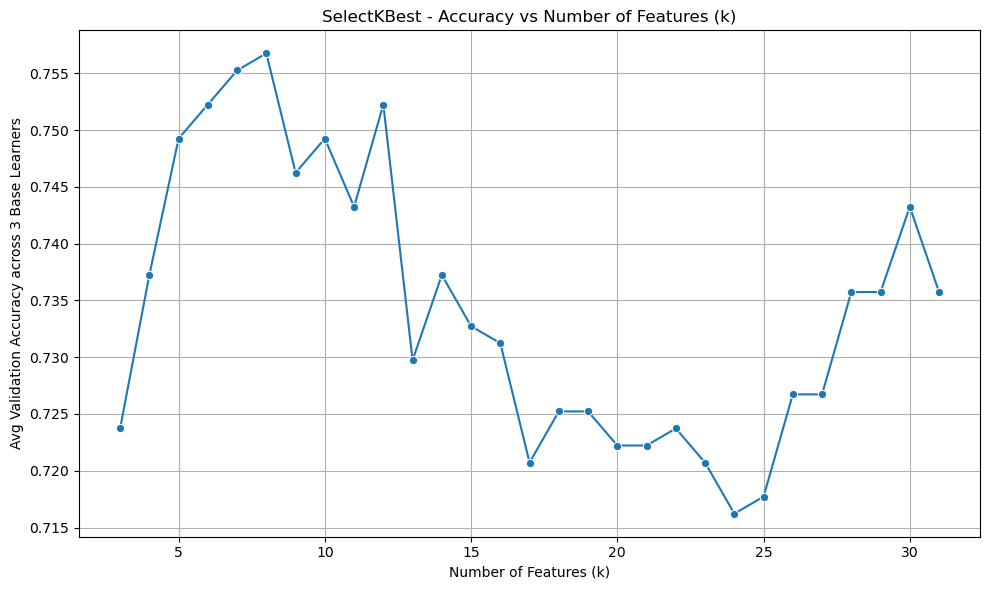


✅ Best k found: 8 with accuracy: 0.7568


In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Step 1: Remove highly correlated features
def correlation_filter(df, threshold=0.90):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    return df.drop(columns=to_drop), to_drop

X_train_filtered, dropped_cols = correlation_filter(X_train)
X_val_filtered = X_val.drop(columns=dropped_cols)
X_test_filtered = X_test.drop(columns=dropped_cols)

print(f"Dropped {len(dropped_cols)} highly correlated features: {dropped_cols}")

# Step 2: Try different values of k for SelectKBest
results = []
feature_names = X_train_filtered.columns
max_k = max(25, len(feature_names))  # don't exceed available features
acc = 0
for k in range(3, max_k + 1):
    acc = 0
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X_train_filtered, y_train)

    selected_cols = feature_names[selector.get_support()]
    
    # Subset the data
    X_train_k = X_train_filtered[selected_cols]
    X_val_k = X_val_filtered[selected_cols]
    
    #LR 
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_k, y_train)
    accuracy = model.score(X_val_k, y_val)
    
    acc += accuracy

    #RF 
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_k, y_train)
    accuracy = model.score(X_val_k, y_val)
    acc += accuracy

    # XGBoost
    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train_k, y_train)
    accuracy = model.score(X_val_k, y_val)
    acc += accuracy
    acc /= 3

    results.append((k, acc))

# Step 3: Plot accuracy vs. k
results_df = pd.DataFrame(results, columns=["k", "Validation Accuracy"])
plt.figure(figsize=(10,6))
sns.lineplot(x="k", y="Validation Accuracy", data=results_df, marker="o")
plt.title("SelectKBest - Accuracy vs Number of Features (k)")
plt.xlabel("Number of Features (k)")
plt.ylabel("Avg Validation Accuracy across 3 Base Learners")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Optional - get best k and re-run final model
best_k = results_df.loc[results_df["Validation Accuracy"].idxmax(), "k"]
print(f"\n✅ Best k found: {int(best_k)} with accuracy: {results_df['Validation Accuracy'].max():.4f}")

# 11 features is optimal based on the plot



Final selected features (k=12):
['Diff_MOR', 'Diff_ORtg', 'Diff_avg_FGA', 'Diff_avg_Score', 'Diff_SchedStrengthNetRtg', 'Diff_avg_Ast', 'Diff_avg_Blk', 'Diff_avg_TO', 'Diff_avg_opponent_DR', 'Diff_avg_OR', 'Diff_avg_PointDiff', 'Diff_Drtg']

✅ Validation accuracy with k=12 features: 0.7568

Feature Importance (F-score + Coefficient):
                     Feature     F_score  Coefficient
1                  Diff_ORtg  712.830303     2.475123
11                 Diff_Drtg  679.510736    -2.156553
0                   Diff_MOR  670.764972     1.941315
2               Diff_avg_FGA   80.885867     0.642893
10        Diff_avg_PointDiff  493.700562    -0.447853
3             Diff_avg_Score  144.796767    -0.288310
4   Diff_SchedStrengthNetRtg  696.690362     0.286744
9                Diff_avg_OR   61.186905    -0.277957
8       Diff_avg_opponent_DR   73.879314    -0.178922
5               Diff_avg_Ast  106.978071    -0.140526
7                Diff_avg_TO   60.601292     0.047948
6              

/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_78435/4175757126.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


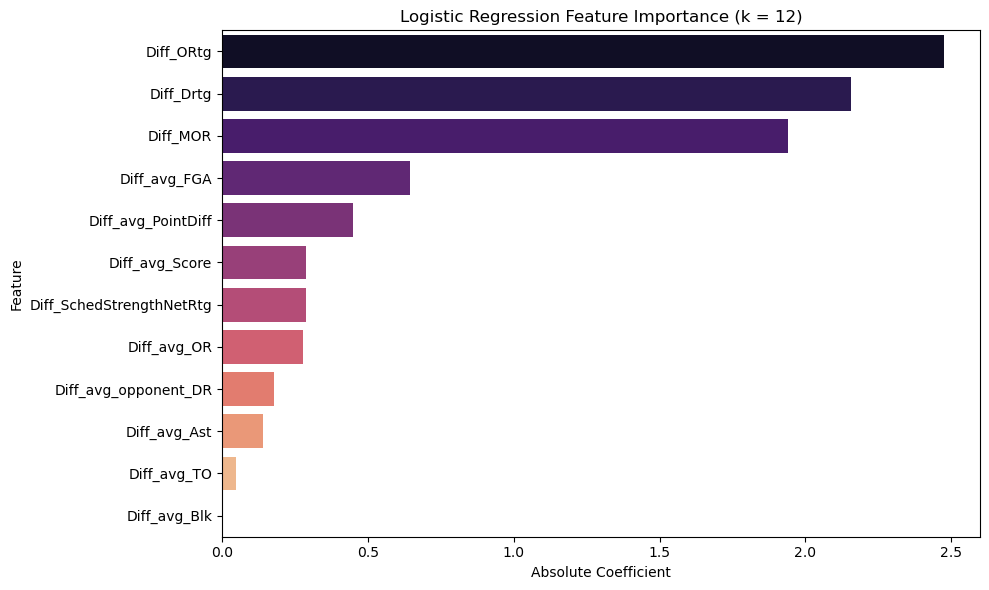

In [264]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

best_k = 12
# 1. Refit SelectKBest using the optimal k
optimal_k = int(best_k)  # Assuming best_k is defined
selector = SelectKBest(f_classif, k=optimal_k)
selector.fit(X_train_filtered, y_train)

# 2. Get final selected feature names
final_selected_features = X_train_filtered.columns[selector.get_support()]
print(f"\nFinal selected features (k={optimal_k}):")
print(final_selected_features.tolist())

# 3. Transform datasets using only selected features
X_train_selected = selector.transform(X_train_filtered)
X_val_selected = selector.transform(X_val_filtered)
X_test_selected = selector.transform(X_test_filtered)


# 4. Fit model on selected features
model = LogisticRegression(max_iter=1000)
model.fit(X_train_selected, y_train)

# 5. Evaluate on validation set
y_val_pred = model.predict(X_val_selected)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"\n✅ Validation accuracy with k={optimal_k} features: {val_acc:.4f}")

# 6. Inspect the final feature importance
feature_importance_df = pd.DataFrame({
    "Feature": final_selected_features,
    "F_score": selector.scores_[selector.get_support()],
    "Coefficient": model.coef_[0]
})

# Optional: Sort by absolute coefficient importance
feature_importance_df["Abs_Coefficient"] = np.abs(feature_importance_df["Coefficient"])
feature_importance_df = feature_importance_df.sort_values(by="Abs_Coefficient", ascending=False)

print("\nFeature Importance (F-score + Coefficient):")
print(feature_importance_df[["Feature", "F_score", "Coefficient"]])

# 7. Plot bar chart of feature importance by coefficient magnitude
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df,
    y="Feature", x="Abs_Coefficient", palette="magma"
)
plt.title(f"Logistic Regression Feature Importance (k = {optimal_k})")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Feature importance: because it is difficult to know how many attributes to limit to

In [265]:
''' import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get F-scores and p-values
f_scores = selector.scores_
p_values = selector.pvalues_

# Create DataFrame of all features and their scores
feature_scores_df = pd.DataFrame({
    "Feature": X_train.columns,
    "F_score": f_scores,
    "p_value": p_values
})

# Filter only selected features
selected_feature_scores = feature_scores_df[feature_scores_df["Feature"].isin(final_selected_feature_names)]

# Sort by importance (descending)
selected_feature_scores = selected_feature_scores.sort_values(by="F_score", ascending=False)

# Display
print(selected_feature_scores)

# Optional: Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x="F_score", y="Feature", data=selected_feature_scores, palette="viridis")
plt.title("Feature Importance (F-score from SelectKBest)")
plt.xlabel("F-score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
'''

' import matplotlib.pyplot as plt\nimport seaborn as sns\nimport pandas as pd\n\n# Get F-scores and p-values\nf_scores = selector.scores_\np_values = selector.pvalues_\n\n# Create DataFrame of all features and their scores\nfeature_scores_df = pd.DataFrame({\n    "Feature": X_train.columns,\n    "F_score": f_scores,\n    "p_value": p_values\n})\n\n# Filter only selected features\nselected_feature_scores = feature_scores_df[feature_scores_df["Feature"].isin(final_selected_feature_names)]\n\n# Sort by importance (descending)\nselected_feature_scores = selected_feature_scores.sort_values(by="F_score", ascending=False)\n\n# Display\nprint(selected_feature_scores)\n\n# Optional: Plot the feature importances\nplt.figure(figsize=(10, 6))\nsns.barplot(x="F_score", y="Feature", data=selected_feature_scores, palette="viridis")\nplt.title("Feature Importance (F-score from SelectKBest)")\nplt.xlabel("F-score")\nplt.ylabel("Feature")\nplt.tight_layout()\nplt.show()\n'

In [266]:
y_train.value_counts()

win
1.0    1248
0.0    1248
Name: count, dtype: int64

In [267]:
'''# Get feature importance scores
feature_scores = selector.scores_

# Create a DataFrame to display feature names and their scores
feature_importance = pd.DataFrame({
    "Feature": X_train_filtered.columns,
    "Score": feature_scores
}).sort_values(by="Score", ascending=False)
print(feature_importance)'''

'# Get feature importance scores\nfeature_scores = selector.scores_\n\n# Create a DataFrame to display feature names and their scores\nfeature_importance = pd.DataFrame({\n    "Feature": X_train_filtered.columns,\n    "Score": feature_scores\n}).sort_values(by="Score", ascending=False)\nprint(feature_importance)'

We see a drastic drop in feature importance after 9 features

# Export csvs 

Exporting reduced datasets:

In [268]:

X_train_selected_df = pd.DataFrame(X_train_selected, columns=final_selected_features)
X_train_selected_df.to_csv("train_test_split/X_train_reduced.csv", index = False)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=final_selected_features)
X_test_selected_df.to_csv("train_test_split/X_test_reduced.csv", index = False) # Got massey data for 2025
X_val_selected_df = pd.DataFrame(X_val_selected, columns=final_selected_features)
X_val_selected_df.to_csv("train_test_split/X_validation_reduced.csv", index = False)


Attributes and label for each reduced dataset

In [269]:
train_selected_df = pd.DataFrame(X_train_selected, columns=final_selected_features)
train_selected_df["win"] = y_train.values
train_selected_df.to_csv("train_test_split/train_reduced.csv", index = False)

test_selected_df = pd.DataFrame(X_test_selected, columns=final_selected_features)
test_selected_df["win"] = y_test.values
test_selected_df.to_csv("train_test_split/test_reduced.csv", index = False) # Got massey data for 2025


val_selected_df = pd.DataFrame(X_val_selected, columns=final_selected_features)
val_selected_df["win"] = y_val.values
val_selected_df.to_csv("train_test_split/validation_reduced.csv", index = False)

Missing values:
 Diff_MOR                    0
Diff_ORtg                   0
Diff_avg_FGA                0
Diff_avg_Score              0
Diff_SchedStrengthNetRtg    0
Diff_avg_Ast                0
Diff_avg_Blk                0
Diff_avg_TO                 0
Diff_avg_opponent_DR        0
Diff_avg_OR                 0
Diff_avg_PointDiff          0
Diff_Drtg                   0
win                         0
dtype: int64


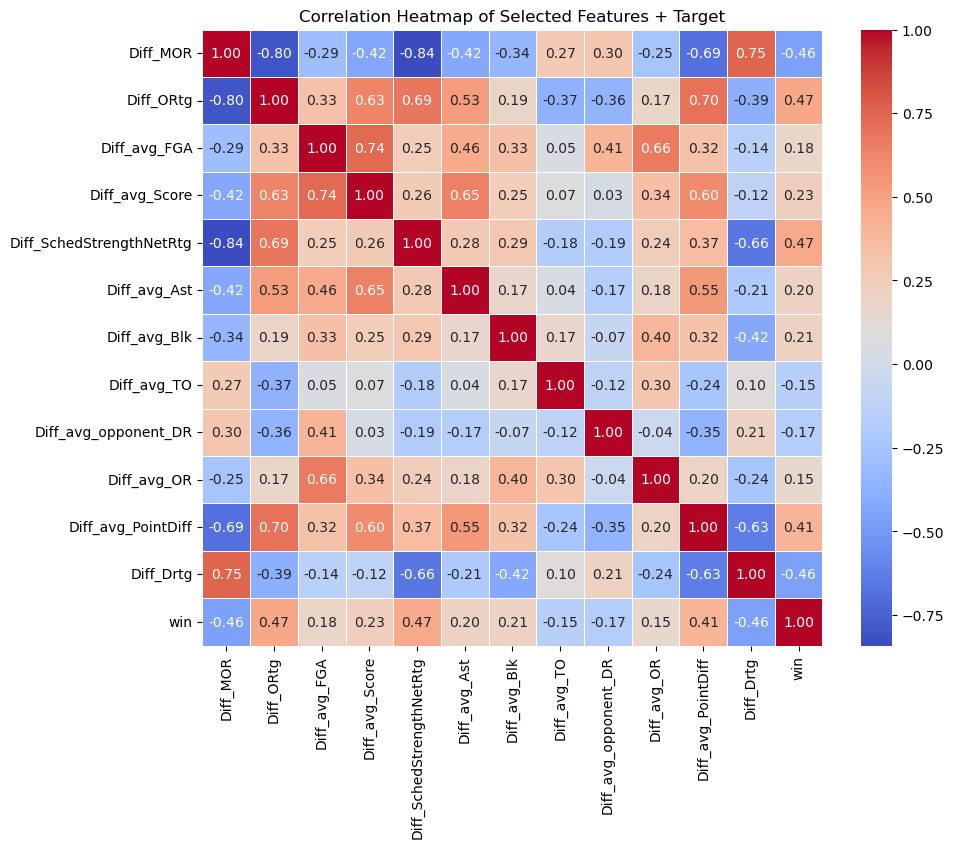

In [270]:
# Step 2: Add target column to selected features
numeric_with_target = train_selected_df.copy()
#numeric_with_target['target (win)'] = y_train.values

# Step 3: Check for nulls (optional but good to debug)
print("Missing values:\n", numeric_with_target.isnull().sum())

# Step 4: Correlation matrix + heatmap
corr_matrix = numeric_with_target.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features + Target")
plt.show()

Exporting full datasets:

In [271]:
X_train.to_csv("train_test_split/X_train.csv", index = False)
X_test.to_csv("train_test_split/X_test.csv", index = False)
X_val.to_csv("train_test_split/X_validation.csv", index = False)

Exporting dataset labels (for reduced and full datasets:)

In [272]:
y_train.to_csv("train_test_split/y_train.csv", index = False)
y_val.to_csv("train_test_split/y_validation.csv", index = False)
# y_test.to_csv() #don't have y test yet because we don't have the labels for 2025 yet (we have attributes - which teams played)

# Prelim Models


## Logistic Regression

In [273]:
# Full dataset - all features:
og_logreg = LogisticRegression(max_iter=1000, random_state=42)
og_logreg.fit(X_train, y_train)
y_pred = og_logreg.predict(X_val)

# Generate report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       111
           1       0.80      0.80      0.80       111

    accuracy                           0.80       222
   macro avg       0.80      0.80      0.80       222
weighted avg       0.80      0.80      0.80       222



In [274]:
# reduced dataset 
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_val_selected)

# Generate report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       111
           1       0.76      0.76      0.76       111

    accuracy                           0.76       222
   macro avg       0.76      0.76      0.76       222
weighted avg       0.76      0.76      0.76       222



In [275]:
from sklearn.inspection import permutation_importance

result1 = permutation_importance(model, X_val_selected, y_val, n_repeats=10, random_state=42)
sorted_idx = result1.importances_mean.argsort()
sorted_idx

array([ 7,  6,  3,  4,  8,  5,  9, 10,  2,  0, 11,  1])

### Try using training instance weights by years (2 different ways)

Alpha as base


In [276]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np
from sklearn.neural_network import MLPClassifier


In [277]:
alphas = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
val_accuracies = []
avg_val_accuracy = 0
for alpha in alphas:
    avg_val_accuracy = 0
    weights = alpha ** (2023 - train['Season'])
    #LR 
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_selected, y_train, sample_weight=weights)
    accuracy = model.score(X_val_selected, y_val)
    
    avg_val_accuracy += accuracy

    #RF 
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_selected, y_train, sample_weight=weights)
    accuracy = model.score(X_val_selected, y_val)
    avg_val_accuracy += accuracy

    # XGBoost
    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train_selected, y_train, sample_weight=weights)
    accuracy = model.score(X_val_selected, y_val)
    avg_val_accuracy += accuracy
    avg_val_accuracy /= 3

    print("Avg val accuracy for alpha of " + str(alpha) + " is " + str(avg_val_accuracy))
    val_accuracies.append(avg_val_accuracy)
        


Avg val accuracy for alpha of 0.001 is 0.7252252252252251
Avg val accuracy for alpha of 0.01 is 0.7207207207207208
Avg val accuracy for alpha of 0.1 is 0.7177177177177176
Avg val accuracy for alpha of 0.2 is 0.7207207207207208
Avg val accuracy for alpha of 0.3 is 0.7192192192192192
Avg val accuracy for alpha of 0.4 is 0.7297297297297298
Avg val accuracy for alpha of 0.5 is 0.7327327327327328
Avg val accuracy for alpha of 0.6 is 0.7207207207207208
Avg val accuracy for alpha of 0.7 is 0.7207207207207208
Avg val accuracy for alpha of 0.8 is 0.7312312312312312
Avg val accuracy for alpha of 0.9 is 0.7372372372372372
Avg val accuracy for alpha of 1.0 is 0.7522522522522523


Text(0.5, 1.0, 'Validation Accuracy vs Alpha Value in Exponential Decay Formula')

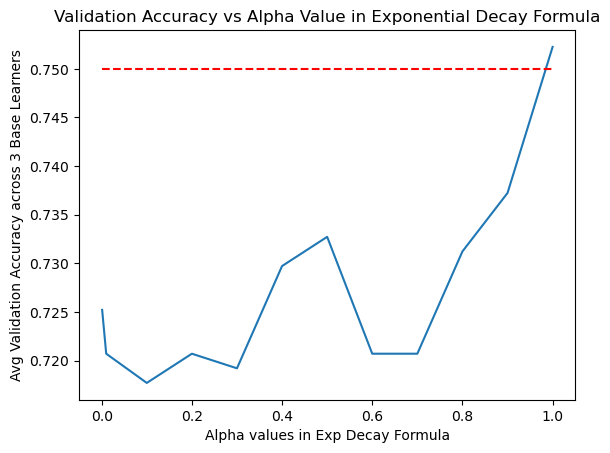

In [397]:
plt.plot(alphas, val_accuracies)
plt.hlines(y=0.75, xmin=0, xmax=1, color='red', linestyle='--')
plt.xlabel("Alpha values in Exp Decay Formula")
plt.ylabel("Avg Validation Accuracy across 3 Base Learners")
plt.title("Validation Accuracy vs Alpha Value in Exponential Decay Formula")

Chosen exponential formula : with alpha = 0.9

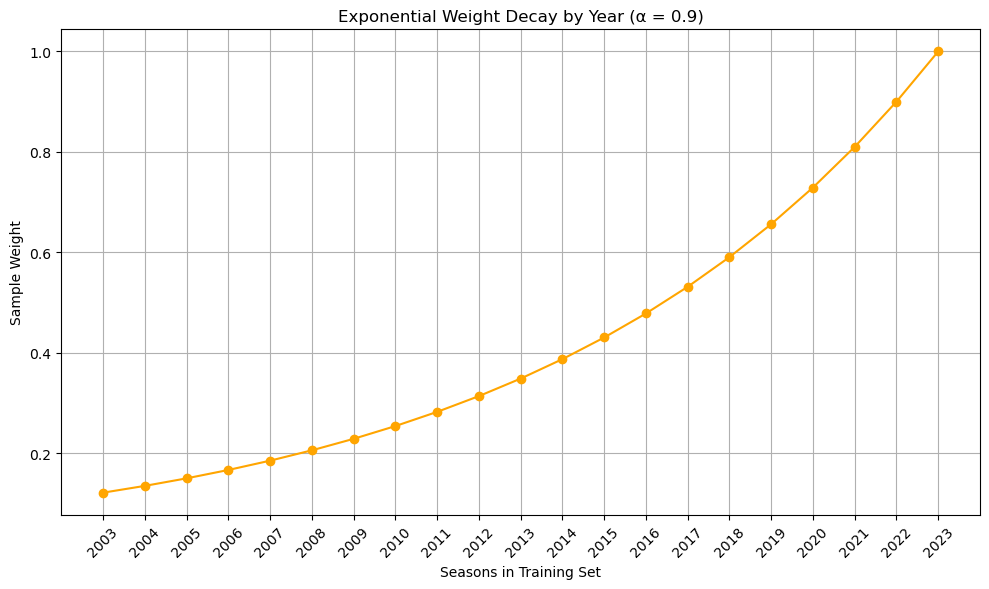

In [279]:

# Parameters
alpha = 0.9
most_recent_year = 2023
years = np.arange(2003, most_recent_year + 1)

# Exponential weights: alpha^(most_recent_year - year)
year_weights = 0.9 ** (most_recent_year - years)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, year_weights, marker='o', color='orange')
plt.title(f"Exponential Weight Decay by Year (α = {alpha})")
plt.xlabel("Seasons in Training Set")
plt.ylabel("Sample Weight")
plt.xticks(years, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# explain 0.7 as alpha

e as base

In [280]:
import numpy as np
lambdas = [0.001, 0.01, 0.1,  0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 10, 50]
for my_lambda in lambdas:
    weights = np.exp(-my_lambda * (2023 - train['Season']))
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_selected, y_train, sample_weight=weights)
    accuracy = model.score(X_val_selected, y_val)
    print("Accuracy for lambda of " + str(my_lambda) + " is " + str(accuracy))
        

Accuracy for lambda of 0.001 is 0.7567567567567568
Accuracy for lambda of 0.01 is 0.7567567567567568
Accuracy for lambda of 0.1 is 0.7657657657657657
Accuracy for lambda of 0.2 is 0.7567567567567568
Accuracy for lambda of 0.3 is 0.7297297297297297
Accuracy for lambda of 0.5 is 0.7117117117117117
Accuracy for lambda of 0.6 is 0.7387387387387387
Accuracy for lambda of 0.7 is 0.7297297297297297
Accuracy for lambda of 0.8 is 0.7207207207207207
Accuracy for lambda of 0.9 is 0.7207207207207207
Accuracy for lambda of 1.0 is 0.7207207207207207
Accuracy for lambda of 10 is 0.7117117117117117
Accuracy for lambda of 50 is 0.5


### Try truncating training to 5 most recent years 

In [281]:
train_mostrecent = train[train['Season'] >= 2018]  
train_mostrecent["Season"].value_counts()

Season
2018.0    134
2019.0    134
2022.0    134
2021.0    132
Name: count, dtype: int64

In [401]:
avg_val_accuracies = []
n_years_training = []
avg_val_accuracy = 0
for i in range(2013, 2022):
    year_diff = 2022 - i
    n_years_training.append(year_diff)
    avg_val_accuracy = 0
    # Create a boolean mask for seasons between 2018 and 2023 (inclusive)
    season_mask = train["Season"].between(i, 2022)  # True for rows in the range
    # Apply the mask to X_train and y_train
    X_train_recent= X_train_selected[season_mask]
    y_train_recent = y_train[season_mask]
                    
    # reduced dataset 
    #LR 
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_recent, y_train_recent)
    accuracy = model.score(X_val_selected, y_val)
    avg_val_accuracy += accuracy

    #RF 
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_selected, y_train, sample_weight=weights)
    accuracy = model.score(X_val_selected, y_val)
    avg_val_accuracy += accuracy

    # XGBoost
    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train_selected, y_train, sample_weight=weights)
    accuracy = model.score(X_val_selected, y_val)
    avg_val_accuracy += accuracy
    avg_val_accuracy /= 3
    avg_val_accuracies.append(avg_val_accuracy)
    print("Avg validation for using training data from " + str(i) + " season is " + str(avg_val_accuracy))


Avg validation for using training data from 2013 season is 0.6711711711711712
Avg validation for using training data from 2014 season is 0.6651651651651652
Avg validation for using training data from 2015 season is 0.6531531531531531
Avg validation for using training data from 2016 season is 0.6531531531531531
Avg validation for using training data from 2017 season is 0.6621621621621622
Avg validation for using training data from 2018 season is 0.6591591591591591
Avg validation for using training data from 2019 season is 0.6531531531531531
Avg validation for using training data from 2020 season is 0.6561561561561562
Avg validation for using training data from 2021 season is 0.6561561561561562


Text(0.5, 1.0, 'Year Range of Training Data vs Avg Validation Accuracy')

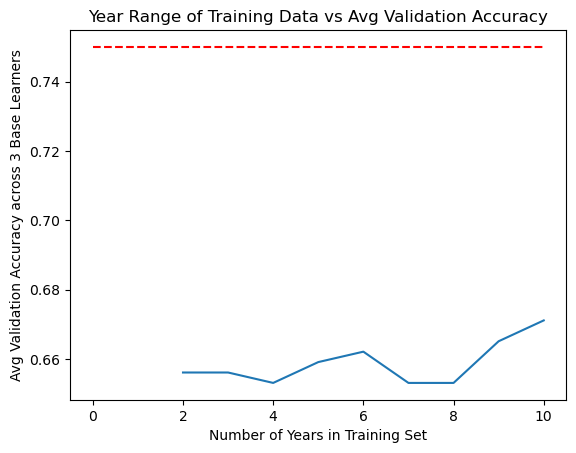

In [400]:
plt.plot(n_years_training, avg_val_accuracies)
plt.hlines(y=0.75, xmin=0, xmax=10, color='red', linestyle='--')
plt.xlabel("Number of Years in Training Set")
plt.ylabel("Avg Validation Accuracy across 3 Base Learners")
plt.title("Year Range of Training Data vs Avg Validation Accuracy")

## Random Forest

Full Dataset

In [284]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

# Generate report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.71      0.71       111
           1       0.71      0.69      0.70       111

    accuracy                           0.70       222
   macro avg       0.70      0.70      0.70       222
weighted avg       0.70      0.70      0.70       222



In [285]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X_val, y_val, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()
sorted_idx

array([39, 35, 36, 28, 11,  7, 14, 33, 31, 18, 37, 21,  3, 23, 25, 19,  6,
       10, 12, 22,  2, 29,  9, 26, 16, 34, 27,  0, 17, 15, 13, 24, 30,  8,
        4,  1, 32,  5, 20, 38])

Reduced Dataset

In [286]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_val_selected)

# Generate report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       111
           1       0.74      0.76      0.75       111

    accuracy                           0.74       222
   macro avg       0.74      0.74      0.74       222
weighted avg       0.74      0.74      0.74       222



Since there are minimal changes between reduced dataset and full dataset we can safel use reduced dataset of best features

In [287]:
from sklearn.inspection import permutation_importance

result2 = permutation_importance(clf, X_val_selected, y_val, n_repeats=10, random_state=42)
sorted_idx = result2.importances_mean.argsort()
sorted_idx

array([ 6,  2,  5, 10,  9,  3,  8,  0,  7,  4, 11,  1])

## Gradient Boosting

Full dataset

In [288]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)

# Generate report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.74      0.74       111
           1       0.74      0.73      0.73       111

    accuracy                           0.73       222
   macro avg       0.73      0.73      0.73       222
weighted avg       0.73      0.73      0.73       222



In [289]:
from sklearn.inspection import permutation_importance

result = permutation_importance(gb, X_val, y_val, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()
sorted_idx

array([ 7, 18, 17, 26, 36, 39, 19,  4, 16,  9, 24,  8, 10, 11, 25, 15, 31,
       12, 28, 14, 34,  2, 37, 32, 29, 13,  0,  3, 35, 23, 22, 21, 33, 27,
       30,  6,  1, 20, 38,  5])

Reduced dataset

In [290]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_selected, y_train)
y_pred = gb.predict(X_val_selected)

# Generate report
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.77      0.76       111
           1       0.76      0.75      0.75       111

    accuracy                           0.76       222
   macro avg       0.76      0.76      0.76       222
weighted avg       0.76      0.76      0.76       222



In [291]:
from sklearn.inspection import permutation_importance

result3 = permutation_importance(gb, X_val_selected, y_val, n_repeats=10, random_state=42)
sorted_idx = result3.importances_mean.argsort()
sorted_idx

array([10,  3,  8,  5,  2,  7,  6,  9,  0,  4, 11,  1])

Permutation importance ranks which features the model is learning the most. we want our models to prioritize different features

In [292]:
'''
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Custom feature order (index-based)
custom_order = np.array([2, 0, 3, 6, 4, 5, 1, 8, 7])
ordered_feature_names = X_val.columns[custom_order]

# Create DataFrame with results in the custom order
perm_df = pd.DataFrame({
    'Feature': ordered_feature_names,
    'LogReg': result1.importances_mean[custom_order],
    'RandomForest': result2.importances_mean[custom_order],
    'GradientBoost': result3.importances_mean[custom_order]
})

# Optional: Melt for plotting
perm_df_melted = perm_df.melt(id_vars='Feature', var_name='Model', value_name='Importance')

# 📊 Plot the importances
plt.figure(figsize=(12, 6))
sns.barplot(data=perm_df_melted, x='Importance', y='Feature', hue='Model')
plt.title('Permutation Importances by Model (Validation Set)')
plt.tight_layout()
plt.show()'''


"\nfrom sklearn.inspection import permutation_importance\nimport matplotlib.pyplot as plt\nimport numpy as np\nimport pandas as pd\n\n# Custom feature order (index-based)\ncustom_order = np.array([2, 0, 3, 6, 4, 5, 1, 8, 7])\nordered_feature_names = X_val.columns[custom_order]\n\n# Create DataFrame with results in the custom order\nperm_df = pd.DataFrame({\n    'Feature': ordered_feature_names,\n    'LogReg': result1.importances_mean[custom_order],\n    'RandomForest': result2.importances_mean[custom_order],\n    'GradientBoost': result3.importances_mean[custom_order]\n})\n\n# Optional: Melt for plotting\nperm_df_melted = perm_df.melt(id_vars='Feature', var_name='Model', value_name='Importance')\n\n# 📊 Plot the importances\nplt.figure(figsize=(12, 6))\nsns.barplot(data=perm_df_melted, x='Importance', y='Feature', hue='Model')\nplt.title('Permutation Importances by Model (Validation Set)')\nplt.tight_layout()\nplt.show()"

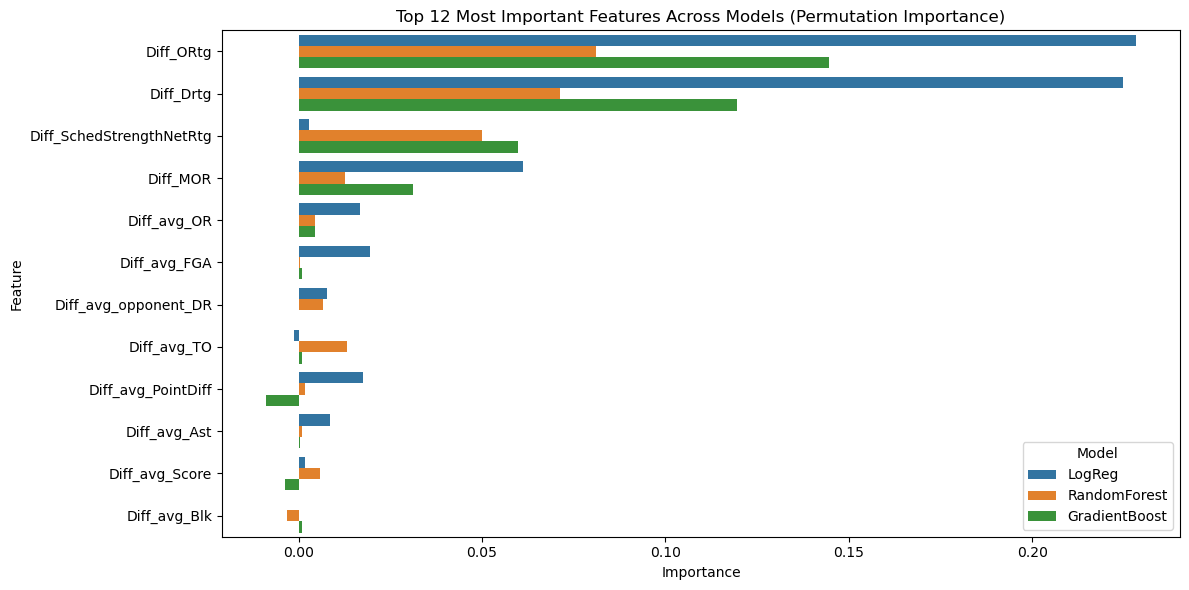

In [293]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Build initial DataFrame
perm_df = pd.DataFrame({
    'Feature': X_val_selected_df.columns,
    'LogReg': result1.importances_mean,
    'RandomForest': result2.importances_mean,
    'GradientBoost': result3.importances_mean
})

# Calculate average importance across models
perm_df['Average'] = perm_df[['LogReg', 'RandomForest', 'GradientBoost']].mean(axis=1)

# Sort by average importance and take top N
top_n = 12
top_features_df = perm_df.sort_values('Average', ascending=False).head(top_n)
top_features_df= top_features_df.drop(columns=["Average"])
# Melt for seaborn barplot
perm_df_melted = top_features_df.melt(id_vars='Feature', var_name='Model', value_name='Importance')


# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=perm_df_melted, x='Importance', y='Feature', hue='Model')
plt.title(f'Top {top_n} Most Important Features Across Models (Permutation Importance)')
plt.tight_layout()
plt.show()


## Apply Exponential Decay for Year weights w/ Alpha = 0.5

In [294]:
from sklearn.metrics import roc_auc_score

In [295]:
alpha = 0.9
final_weights = alpha ** (2023 - train['Season'])

In [451]:

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_selected, y_train, sample_weight=final_weights)
y_pred = logreg.predict(X_val_selected)

# Generate report
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       111
           1       0.77      0.77      0.77       111

    accuracy                           0.77       222
   macro avg       0.77      0.77      0.77       222
weighted avg       0.77      0.77      0.77       222

ROC AUC Score: 0.7657657657657657


In [453]:
print("ROC AUC Score:", roc_auc_score(y_val, logreg.predict_proba(X_val_selected)[:, 1]))

ROC AUC Score: 0.8303709114519926


In [297]:
from sklearn.model_selection import GridSearchCV
# Grid search 
params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}
grid = GridSearchCV(logreg, params, cv=5, scoring='accuracy')
grid.fit(X_train_selected, y_train, sample_weight=final_weights)

# Best model and params
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV Score: 0.7716248496993988


In [298]:
best_lr = grid.best_estimator_
y_pred = best_lr.predict(X_val_selected)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))

# grid search improved validation accuracy. use this version

Validation Accuracy: 0.7567567567567568
ROC AUC Score: 0.7657657657657657


In [299]:
best_lr = logreg

In [300]:
logreg_importance = permutation_importance(best_lr, X_val_selected, y_val, n_repeats=10, random_state=42)
sorted_idx = logreg_importance.importances_mean.argsort()
sorted_idx

array([ 6,  8,  5,  4,  7,  3, 10,  9,  2,  0, 11,  1])

In [301]:
clf = RandomForestClassifier()
clf.fit(X_train_selected, y_train, sample_weight=final_weights)
accuracy = model.score(X_val_selected, y_val)
y_pred = clf.predict(X_val_selected)

# Generate report
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       111
           1       0.77      0.74      0.75       111

    accuracy                           0.76       222
   macro avg       0.76      0.76      0.76       222
weighted avg       0.76      0.76      0.76       222

ROC AUC Score: 0.7567567567567568


In [302]:
# Grid search 
params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(clf, params, cv=5, scoring='accuracy')
grid.fit(X_train_selected, y_train, sample_weight=final_weights)

# Best model and params
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Score: 0.7551975951903808


In [303]:
best_clf = grid.best_estimator_
y_pred = best_clf.predict(X_val_selected)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))

# grid search improves val accuracy

Validation Accuracy: 0.7522522522522522
ROC AUC Score: 0.7522522522522523


In [304]:
clf_importance = permutation_importance(best_clf, X_val_selected, y_val, n_repeats=10, random_state=42)
sorted_idx = clf_importance.importances_mean.argsort()
sorted_idx

array([10,  7,  8,  6,  9,  2,  5,  3,  0,  4, 11,  1])

In [305]:
gb = GradientBoostingClassifier()
gb.fit(X_train_selected, y_train, sample_weight=final_weights)
y_pred = gb.predict(X_val_selected)

# Generate report
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71       111
           1       0.71      0.71      0.71       111

    accuracy                           0.71       222
   macro avg       0.71      0.71      0.71       222
weighted avg       0.71      0.71      0.71       222

ROC AUC Score: 0.7072072072072071


In [306]:
# Grid Seach
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
grid = GridSearchCV(gb, params, cv=5, scoring='accuracy')
grid.fit(X_train_selected, y_train, sample_weight=final_weights)

# Best model and params
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best CV Score: 0.7576104208416833


In [307]:
best_gb = grid.best_estimator_
y_pred = best_gb.predict(X_val_selected)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))



Validation Accuracy: 0.7072072072072072
ROC AUC Score: 0.7072072072072071


In [308]:
# grid search improved performance!
#best_gb = gb

In [309]:
gb_importance = permutation_importance(best_gb, X_val_selected, y_val, n_repeats=10, random_state=42)
sorted_idx = gb_importance.importances_mean.argsort()
sorted_idx

array([10,  7,  9,  5,  0,  6,  8,  2,  3,  4, 11,  1])

### More base learners

In [310]:
# Unfortuantely NN doenst take into account sample_weights param -- try without
# Workaround: 
import numpy as np
import numpy as np
from sklearn.neural_network import MLPClassifier

n_samples = len(X_train_selected)
indices = np.random.choice(
    np.arange(n_samples),
    size=n_samples,
    replace=True,
    p=final_weights / final_weights.sum()
)

X_weighted = X_train_selected[indices]
y_weighted = y_train[indices]


In [311]:
# using weighted version of dataset
from sklearn.neural_network import MLPClassifier
print(MLPClassifier.__module__)
mlp = MLPClassifier(hidden_layer_sizes=(100,),  # 1 hidden layer with 100 neurons
                    activation='relu',
                    solver='adam',
                    max_iter=500,
                    random_state=42)
mlp.fit(X_weighted, y_weighted)
y_pred = mlp.predict(X_val_selected)

# Generate report
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))


sklearn.neural_network._multilayer_perceptron
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       111
           1       0.77      0.72      0.74       111

    accuracy                           0.75       222
   macro avg       0.75      0.75      0.75       222
weighted avg       0.75      0.75      0.75       222

ROC AUC Score: 0.7522522522522523


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [312]:

params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-4, 1e-3, 1e-2],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [500],  # Ensure enough training
    'early_stopping': [True]  # Helps prevent overfitting
}
grid = GridSearchCV(mlp, params, cv=5, scoring='accuracy')
grid.fit(X_weighted, y_weighted)

# Best model and params
print("Best Params:", grid.best_params_)
# best cv score meaning generalization performance
print("Best CV Score:", grid.best_score_)


Best Params: {'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'adam'}
Best CV Score: 0.9074525050100201


In [313]:
best_mlp = grid.best_estimator_
y_pred = best_mlp.predict(X_val_selected)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))

# grid search improved performance!

Validation Accuracy: 0.6891891891891891
ROC AUC Score: 0.6891891891891893


In [314]:
best_mlp = mlp 
# grid search performance was worse

In [315]:
mlp_importance = permutation_importance(best_mlp, X_val_selected, y_val, n_repeats=10, random_state=42)
sorted_idx = mlp_importance.importances_mean.argsort()
sorted_idx

array([ 9,  4,  5,  6,  8, 10,  7,  3,  2,  0, 11,  1])

In [434]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', C=1.0, gamma='scale', probability = True)  # RBF = Gaussian kernel
svc.fit(X_train_selected, y_train, sample_weight=final_weights)
y_pred = svc.predict(X_val_selected)
print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       111
           1       0.75      0.75      0.75       111

    accuracy                           0.75       222
   macro avg       0.75      0.75      0.75       222
weighted avg       0.75      0.75      0.75       222

0.7477477477477478
ROC AUC Score: 0.7477477477477477


In [317]:
# Grid search
params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid = GridSearchCV(svc, params, cv=5, scoring='accuracy')
grid.fit(X_train_selected, y_train, sample_weight=final_weights)

# Best model and params
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)


Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Score: 0.7624096192384769


In [318]:
best_svc = grid.best_estimator_
y_pred = best_svc.predict(X_val_selected)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))

# og was better than grid search

Validation Accuracy: 0.7297297297297297
ROC AUC Score: 0.7297297297297297


In [319]:
best_svc = svc

In [320]:
svc_importance = permutation_importance(best_svc, X_val_selected, y_val, n_repeats=10, random_state=42)
sorted_idx = svc_importance.importances_mean.argsort()
sorted_idx

array([ 6,  8,  7,  3, 10,  2,  5,  9,  0,  4, 11,  1])

### Checking NB Assumptions before Trying

Note we already used correlation plot to see if correlations too high (none above 80%)

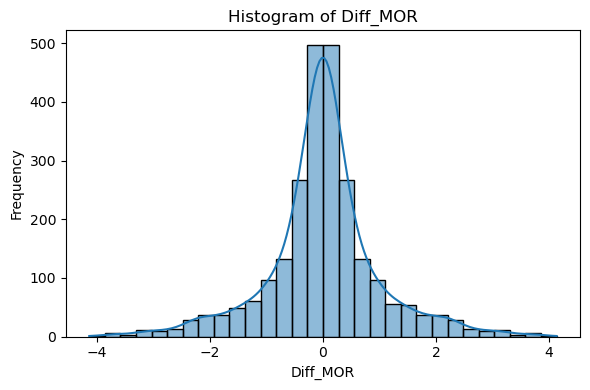

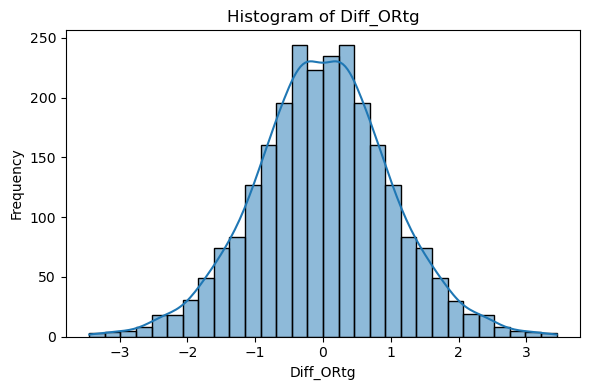

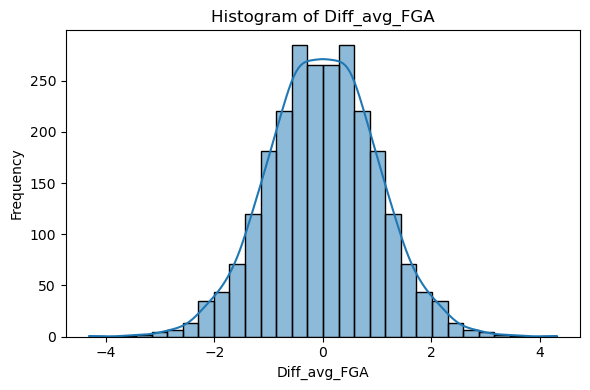

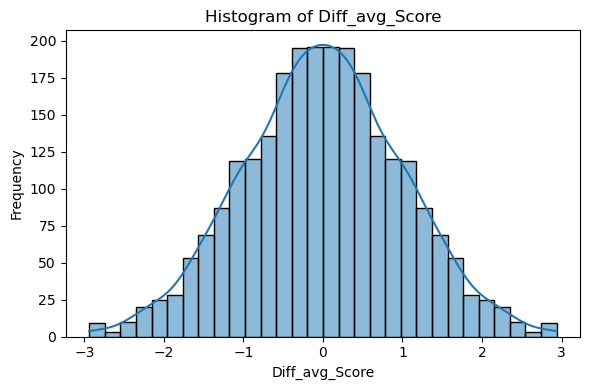

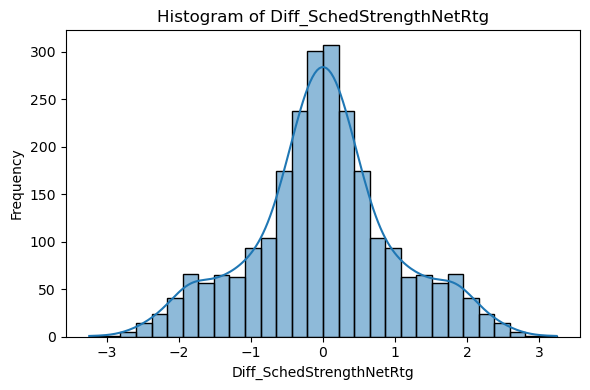

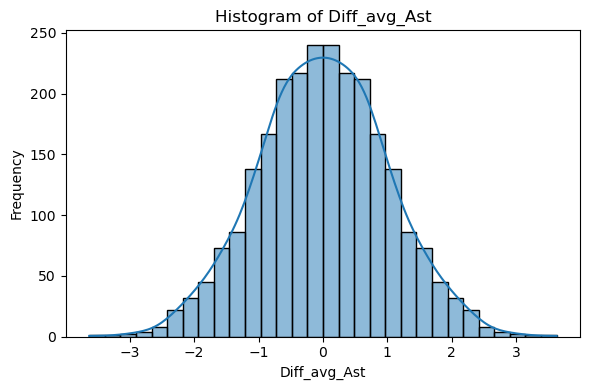

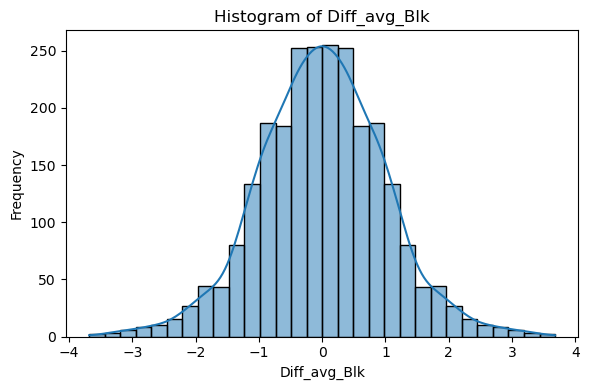

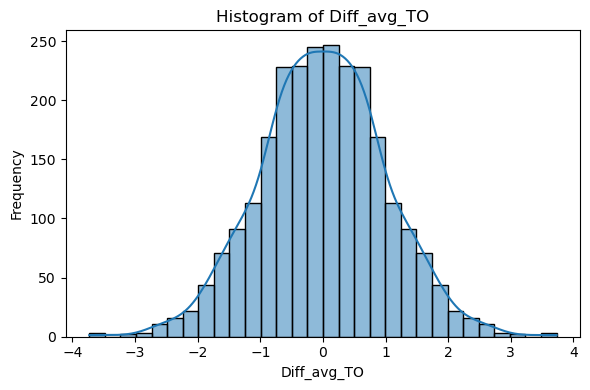

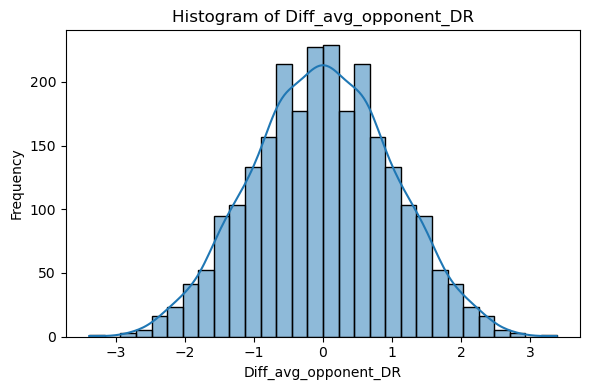

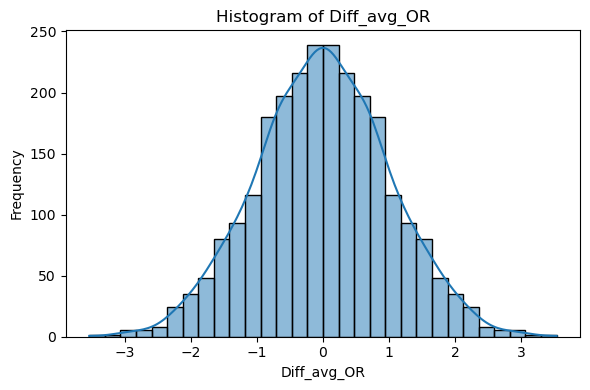

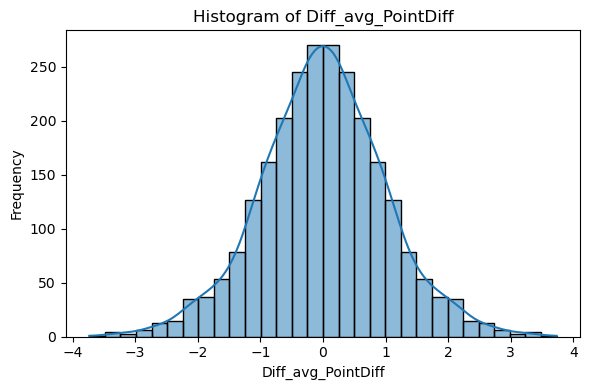

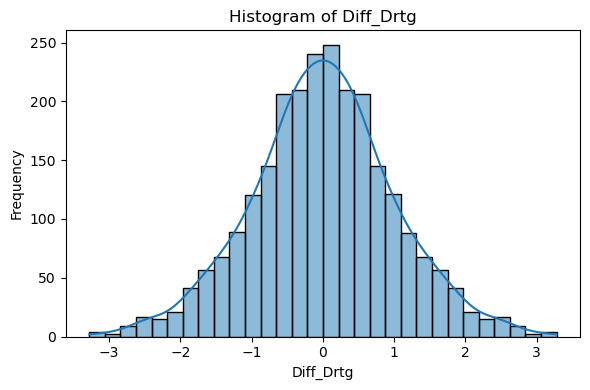

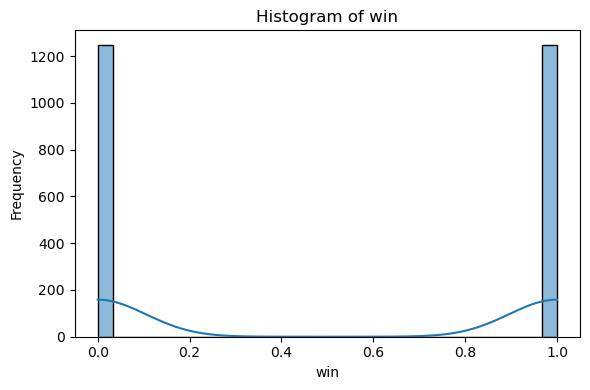

In [321]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through each column in numeric_df and plot separately
for col in numeric_with_target.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=numeric_with_target, x=col, bins=30, kde=True, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [322]:
# and based on correlation plot above, magnitudes of correlation low enough between attributes

In [323]:
from sklearn.naive_bayes import GaussianNB

# Instantiate the model
gnb = GaussianNB()
gnb.fit(X_train_selected, y_train, sample_weight=final_weights)
y_pred = gnb.predict(X_val_selected)
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print("Accuracy", accuracy_score(y_val, y_pred))
# Fit to training data

              precision    recall  f1-score   support

           0       0.69      0.69      0.69       111
           1       0.69      0.69      0.69       111

    accuracy                           0.69       222
   macro avg       0.69      0.69      0.69       222
weighted avg       0.69      0.69      0.69       222

ROC AUC Score: 0.6936936936936937
Accuracy 0.6936936936936937


In [324]:
# Grid search
# Define hyperparameter grid
params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}
grid = GridSearchCV(gnb, params, cv=5, scoring='accuracy')
grid.fit(X_train_selected, y_train, sample_weight=final_weights)

# Best model and params
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Params: {'var_smoothing': 1e-09}
Best CV Score: 0.7287615230460922


In [325]:
best_gnb = grid.best_estimator_
y_pred = best_gnb.predict(X_val_selected)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))

# performance was slightly better with original

Validation Accuracy: 0.6936936936936937
ROC AUC Score: 0.6936936936936937


In [326]:
#best_gnb = gnb 


In [327]:
nb_importance = permutation_importance(best_gnb, X_val_selected, y_val, n_repeats=10, random_state=42)
sorted_idx = nb_importance.importances_mean.argsort()
sorted_idx

array([10,  5,  8,  7,  6,  2,  9,  3,  0,  4,  1, 11])

In [328]:
'''
# Custom feature order (index-based)
custom_order = np.array([8, 1, 3, 6, 5, 0, 4, 2, 7])
ordered_feature_names = X_val.columns[custom_order]

# Create DataFrame with results in the custom order
perm_df = pd.DataFrame({
    'Feature': ordered_feature_names,
    'NB': nb_importance.importances_mean[custom_order],
    'RandomForest': clf_importance.importances_mean[custom_order],
    'GradientBoost': gb_importance.importances_mean[custom_order],
    'SVM': svc_importance.importances_mean[custom_order],
    'LogReg': logreg_importance.importances_mean[custom_order],
    'MLP': mlp_importance.importances_mean[custom_order]
})

# Optional: Melt for plotting
perm_df_melted = perm_df.melt(id_vars='Feature', var_name='Model', value_name='Importance')

# Plot the importances
plt.figure(figsize=(12, 6))
sns.barplot(data=perm_df_melted, x='Importance', y='Feature', hue='Model')
plt.title('Permutation Importances by Model (Validation Set)')
plt.tight_layout()
plt.show()'''

"\n# Custom feature order (index-based)\ncustom_order = np.array([8, 1, 3, 6, 5, 0, 4, 2, 7])\nordered_feature_names = X_val.columns[custom_order]\n\n# Create DataFrame with results in the custom order\nperm_df = pd.DataFrame({\n    'Feature': ordered_feature_names,\n    'NB': nb_importance.importances_mean[custom_order],\n    'RandomForest': clf_importance.importances_mean[custom_order],\n    'GradientBoost': gb_importance.importances_mean[custom_order],\n    'SVM': svc_importance.importances_mean[custom_order],\n    'LogReg': logreg_importance.importances_mean[custom_order],\n    'MLP': mlp_importance.importances_mean[custom_order]\n})\n\n# Optional: Melt for plotting\nperm_df_melted = perm_df.melt(id_vars='Feature', var_name='Model', value_name='Importance')\n\n# Plot the importances\nplt.figure(figsize=(12, 6))\nsns.barplot(data=perm_df_melted, x='Importance', y='Feature', hue='Model')\nplt.title('Permutation Importances by Model (Validation Set)')\nplt.tight_layout()\nplt.show()"

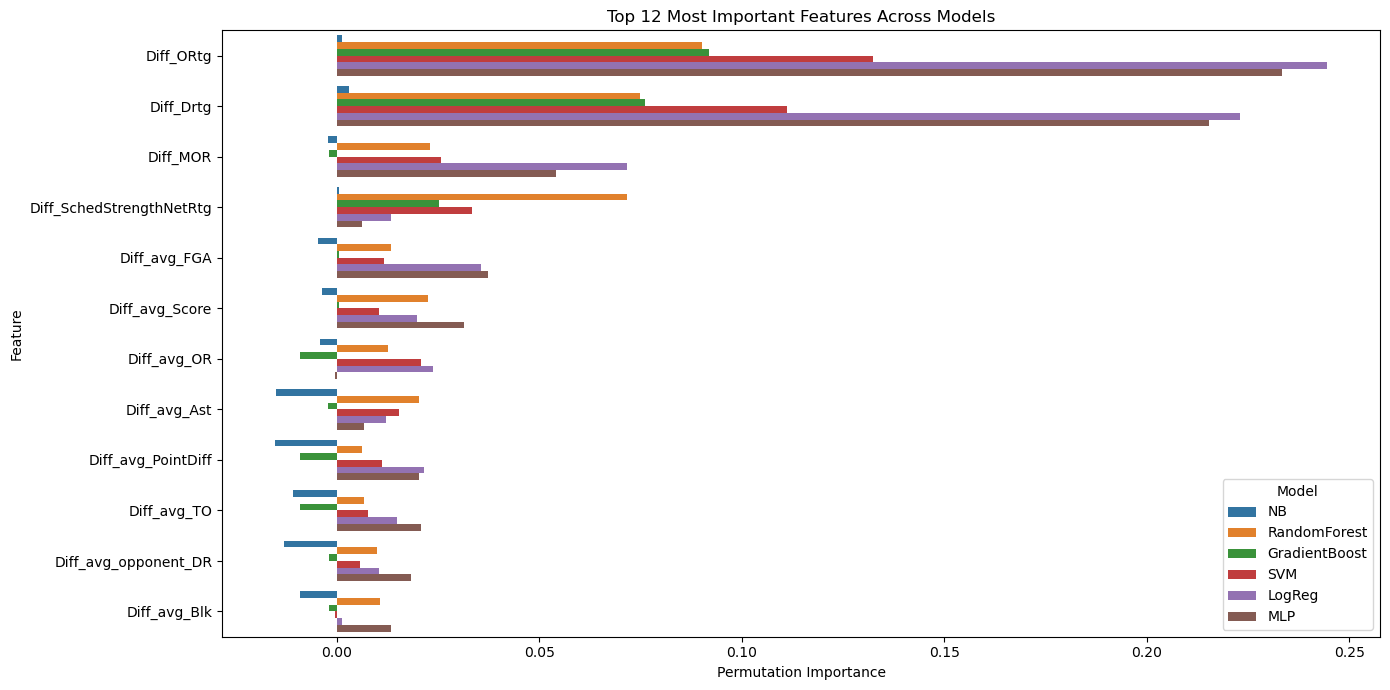

In [329]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Custom order (can be ignored if you want dynamic ranking instead)
custom_order = np.array([ 3, 11,  4, 10,  7,  1,  5,  9,  6,  2,  0,  8])
ordered_feature_names = X_val_selected_df.columns[custom_order]

# Build DataFrame
perm_df = pd.DataFrame({
    'Feature': ordered_feature_names,
    'NB': nb_importance.importances_mean[custom_order],
    'RandomForest': clf_importance.importances_mean[custom_order],
    'GradientBoost': gb_importance.importances_mean[custom_order],
    'SVM': svc_importance.importances_mean[custom_order],
    'LogReg': logreg_importance.importances_mean[custom_order],
    'MLP': mlp_importance.importances_mean[custom_order]
})

# Compute average importance and select top N
perm_df['Average'] = perm_df.drop(columns='Feature').mean(axis=1)
top_n = 12
top_features = perm_df.sort_values('Average', ascending=False).head(top_n)
top_features = top_features.drop(columns='Average')
# Melt for plotting
melted = top_features.melt(id_vars='Feature', var_name='Model', value_name='Importance')

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(data=melted, x='Importance', y='Feature', hue='Model')
plt.title(f'Top {top_n} Most Important Features Across Models')
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.show()


### Comparing Model Similarity

In [330]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, pairwise_distances
from scipy.stats import pearsonr
import numpy as np


def compare_models(model1, model2, X_test, y_test):
    prob_model1 = model1.predict_proba(X_test)[:, 1]
    prob_model2 = model2.predict_proba(X_test)[:, 1]
    preds_model1 = model1.predict(X_test)
    preds_model2 = model2.predict(X_test)

    pearson_corr, _ = pearsonr(prob_model1, prob_model2)
    disagreement_rate = np.mean(preds_model1 != preds_model2)
    kappa = cohen_kappa_score(preds_model1, preds_model2)
    double_fault = np.mean((preds_model1 != y_test) & (preds_model2 != y_test))

    return {
        "pearson_correlation": pearson_corr,
        "disagreement_rate": disagreement_rate,
        "cohen_kappa": kappa,
        "double_fault": double_fault
    }

In [331]:
print(best_mlp)
type(best_mlp)

MLPClassifier(max_iter=500, random_state=42)


sklearn.neural_network._multilayer_perceptron.MLPClassifier

In [332]:
from itertools import combinations
# can avoid comparing sgd because recall of class 1 too low and doesnt have a 
# probabilities function built in
models = [best_lr,best_clf, best_gb, best_mlp, best_svc, best_gnb]
model_pairs = list(combinations(models, 2))
model_pairs

[(LogisticRegression(max_iter=1000, random_state=42),
  RandomForestClassifier(n_estimators=200)),
 (LogisticRegression(max_iter=1000, random_state=42),
  GradientBoostingClassifier()),
 (LogisticRegression(max_iter=1000, random_state=42),
  MLPClassifier(max_iter=500, random_state=42)),
 (LogisticRegression(max_iter=1000, random_state=42), SVC(probability=True)),
 (LogisticRegression(max_iter=1000, random_state=42), GaussianNB()),
 (RandomForestClassifier(n_estimators=200), GradientBoostingClassifier()),
 (RandomForestClassifier(n_estimators=200),
  MLPClassifier(max_iter=500, random_state=42)),
 (RandomForestClassifier(n_estimators=200), SVC(probability=True)),
 (RandomForestClassifier(n_estimators=200), GaussianNB()),
 (GradientBoostingClassifier(), MLPClassifier(max_iter=500, random_state=42)),
 (GradientBoostingClassifier(), SVC(probability=True)),
 (GradientBoostingClassifier(), GaussianNB()),
 (MLPClassifier(max_iter=500, random_state=42), SVC(probability=True)),
 (MLPClassifier

In [333]:
comparisons = {}
seen = set()
for m1, m2 in combinations(models, 2):
    key = tuple(sorted([type(m1).__name__, type(m2).__name__]))
    if key not in seen:
        seen.add(key)
        comparisons[(m1, m2)] = compare_models(m1, m2, X_val_selected, y_val)

In [334]:
len(comparisons)

15

In [335]:
comparisons

{(LogisticRegression(max_iter=1000, random_state=42),
  RandomForestClassifier(n_estimators=200)): {'pearson_correlation': 0.9204399341986842,
  'disagreement_rate': 0.11261261261261261,
  'cohen_kappa': 0.7747747747747747,
  'double_fault': 0.18468468468468469},
 (LogisticRegression(max_iter=1000, random_state=42),
  GradientBoostingClassifier()): {'pearson_correlation': 0.935530158141685,
  'disagreement_rate': 0.11261261261261261,
  'cohen_kappa': 0.7747747747747747,
  'double_fault': 0.2072072072072072},
 (LogisticRegression(max_iter=1000, random_state=42),
  MLPClassifier(max_iter=500, random_state=42)): {'pearson_correlation': 0.8633649857761814,
  'disagreement_rate': 0.13963963963963963,
  'cohen_kappa': 0.7207207207207207,
  'double_fault': 0.17117117117117117},
 (LogisticRegression(max_iter=1000, random_state=42),
  SVC(probability=True)): {'pearson_correlation': 0.9634731899424059, 'disagreement_rate': 0.07207207207207207, 'cohen_kappa': 0.8558558558558559, 'double_fault': 0

In [336]:
# mainly want low double fault and low pearson correlation in probs

In [337]:
accuracies = {
    "LogisticRegression": 0.81,
    "RandomForestClassifier": 0.73,
    "GradientBoostingClassifier": 0.75,
    "MLPClassifier": 0.79,
    "GaussianNB": 0.71,
    "SVC": 0.80
}

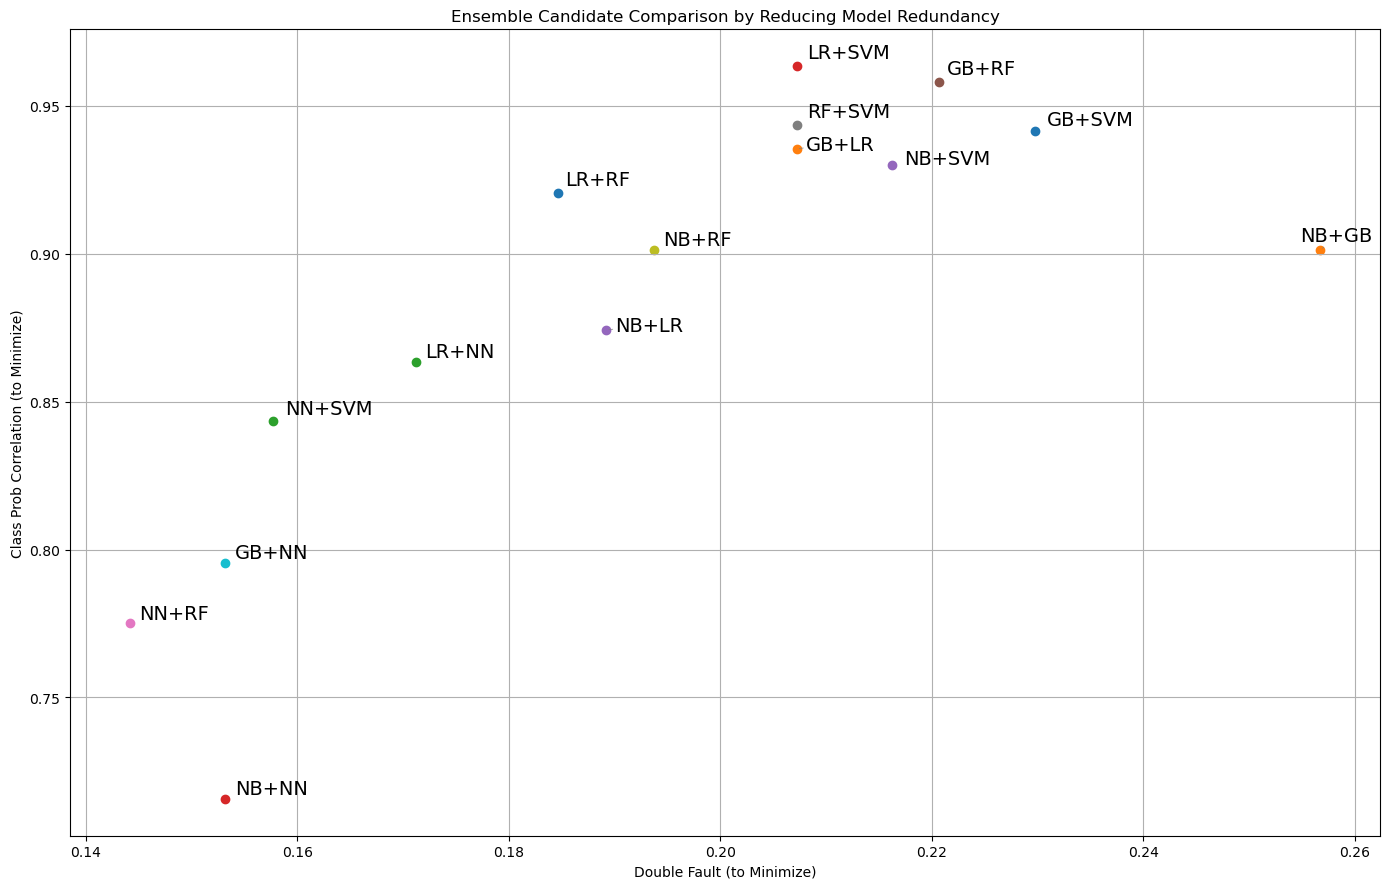

In [338]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
import numpy as np

# Shortened model names
short_names = {
    "LogisticRegression": "LR",
    "RandomForestClassifier": "RF",
    "GradientBoostingClassifier": "GB",
    "MLPClassifier": "NN",
    "GaussianNB": "NB",
    "SVC": "SVM"
}

# Abbreviated label generator
def abbrev(model1, model2):
    types = sorted([type(model1).__name__, type(model2).__name__])  # sort to make pairs consistent
    return f"{short_names[types[0]]}+{short_names[types[1]]}"

filtered = comparisons
# Plotting
plt.figure(figsize=(14, 9))
texts = []
used_coords = set()

# Jitter to prevent overlap
def jitter(x, y, delta=0.001):
    while (round(x, 4), round(y, 4)) in used_coords:
        x += np.random.uniform(-delta, delta)
        y += np.random.uniform(-delta, delta)
    used_coords.add((round(x, 4), round(y, 4)))
    return x, y

# Scatter points
for (m1, m2), metrics in filtered.items():
    x = metrics["double_fault"]
    y = metrics["pearson_correlation"]
    label = abbrev(m1, m2)
    x, y = jitter(x, y)
    plt.scatter(x, y)
    texts.append(plt.text(x, y, label, fontsize=14))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))
plt.title("Ensemble Candidate Comparison by Reducing Model Redundancy")
plt.xlabel("Double Fault (to Minimize)")
plt.ylabel("Class Prob Correlation (to Minimize)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [339]:
# Looks like anything towards bottom left corner may be best

In [340]:
y_pred = best_lr.predict(X_val_selected)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       111
           1       0.77      0.77      0.77       111

    accuracy                           0.77       222
   macro avg       0.77      0.77      0.77       222
weighted avg       0.77      0.77      0.77       222



In [408]:
from sklearn.ensemble import VotingClassifier

# Define base models
voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_clf),
        ('nb', best_gnb) 
    ],
    voting='soft'  # use predicted probabilities
)

# Fit and predict
voting_clf.fit(X_train_selected, y_train)
y_pred = voting_clf.predict(X_val_selected)

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       111
           1       0.71      0.71      0.71       111

    accuracy                           0.71       222
   macro avg       0.71      0.71      0.71       222
weighted avg       0.71      0.71      0.71       222



In [426]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define base estimators
estimators = [
    ('rf', best_clf),
    ('nb', best_mlp)
]

# Base voting classifier (weights will be tuned)
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Define weight combinations to try
param_grid = {
    'weights': [
        [1, 1],
        [2, 1],
        [1, 2],
        [3, 1],
        [1, 3],
        [0.5, 1.5],
        [1.5, 0.5],
    ]
}

# Grid search
grid = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_selected, y_train)

# Best model
best_voting_clf = grid.best_estimator_
print("Best Weights:", grid.best_params_['weights'])

# Evaluate on validation set
y_pred = best_voting_clf.predict(X_val_selected)
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, best_voting_clf.predict_proba(X_val_selected)[:, 1]))


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization

Best Weights: [1, 1]
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       111
           1       0.78      0.76      0.77       111

    accuracy                           0.77       222
   macro avg       0.77      0.77      0.77       222
weighted avg       0.77      0.77      0.77       222

ROC AUC Score: 0.8477396315234154


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [341]:
from sklearn.ensemble import VotingClassifier

# Define base models
voting_clf = VotingClassifier(
    estimators=[
        ('gnb', best_gnb),
        ('nn', best_mlp) 
    ],
    voting='soft'  # use predicted probabilities
)

# Fit and predict
voting_clf.fit(X_train_selected, y_train)
y_pred = voting_clf.predict(X_val_selected)

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       111
           1       0.74      0.74      0.74       111

    accuracy                           0.74       222
   macro avg       0.74      0.74      0.74       222
weighted avg       0.74      0.74      0.74       222



/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [427]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define base estimators
estimators = [
    ('gnb', best_gnb),
    ('nn', best_mlp) 
]

# Base voting classifier (weights will be tuned)
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Define weight combinations to try
param_grid = {
    'weights': [
        [1, 1],
        [2, 1],
        [1, 2],
        [3, 1],
        [1, 3],
        [0.5, 1.5],
        [1.5, 0.5],
    ]
}

# Grid search
grid = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_selected, y_train)

# Best model
best_voting_clf = grid.best_estimator_
print("Best Weights:", grid.best_params_['weights'])

# Evaluate on validation set
y_pred = best_voting_clf.predict(X_val_selected)
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, best_voting_clf.predict_proba(X_val_selected)[:, 1]))


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization

Best Weights: [1, 3]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       111
           1       0.75      0.76      0.75       111

    accuracy                           0.75       222
   macro avg       0.75      0.75      0.75       222
weighted avg       0.75      0.75      0.75       222

ROC AUC Score: 0.8474149825501177


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [342]:
from sklearn.ensemble import VotingClassifier

# Define base models
voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_clf),
        ('nn', best_mlp) 
    ],
    voting='soft'  # use predicted probabilities
)

# Fit and predict
voting_clf.fit(X_train_selected, y_train)
y_pred = voting_clf.predict(X_val_selected)

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.76      0.78      0.77       111
           1       0.78      0.75      0.76       111

    accuracy                           0.77       222
   macro avg       0.77      0.77      0.77       222
weighted avg       0.77      0.77      0.77       222



/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [428]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define base estimators
estimators = [
    ('rf', best_clf),
    ('nn', best_mlp) 
]

# Base voting classifier (weights will be tuned)
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Define weight combinations to try
param_grid = {
    'weights': [
        [1, 1],
        [2, 1],
        [1, 2],
        [3, 1],
        [1, 3],
        [0.5, 1.5],
        [1.5, 0.5],
    ]
}

# Grid search
grid = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_selected, y_train)

# Best model
best_voting_clf = grid.best_estimator_
print("Best Weights:", grid.best_params_['weights'])

# Evaluate on validation set
y_pred = best_voting_clf.predict(X_val_selected)
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, best_voting_clf.predict_proba(X_val_selected)[:, 1]))


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization

Best Weights: [1, 1]
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       111
           1       0.76      0.75      0.75       111

    accuracy                           0.76       222
   macro avg       0.76      0.76      0.76       222
weighted avg       0.76      0.76      0.76       222

ROC AUC Score: 0.8483889294700105


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [407]:
# Define base models
voting_clf = VotingClassifier(
    estimators=[
        ('nn', best_mlp),
        ('gb', best_gb) 
    ],
    voting='soft'  # use predicted probabilities
)

# Fit and predict
voting_clf.fit(X_train_selected, y_train)
y_pred = voting_clf.predict(X_val_selected)

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


              precision    recall  f1-score   support

           0       0.77      0.77      0.77       111
           1       0.77      0.77      0.77       111

    accuracy                           0.77       222
   macro avg       0.77      0.77      0.77       222
weighted avg       0.77      0.77      0.77       222

0.7747747747747747


In [429]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define base estimators
estimators = [
    ('nn', best_mlp),
    ('gb', best_gb)
]

# Base voting classifier (weights will be tuned)
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Define weight combinations to try
param_grid = {
    'weights': [
        [1, 1],
        [2, 1],
        [1, 2],
        [3, 1],
        [1, 3],
        [0.5, 1.5],
        [1.5, 0.5],
    ]
}

# Grid search
grid = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_selected, y_train)

# Best model
best_voting_clf = grid.best_estimator_
print("Best Weights:", grid.best_params_['weights'])

# Evaluate on validation set
y_pred = best_voting_clf.predict(X_val_selected)
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, best_voting_clf.predict_proba(X_val_selected)[:, 1]))


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization

Best Weights: [1, 1]
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       111
           1       0.77      0.77      0.77       111

    accuracy                           0.77       222
   macro avg       0.77      0.77      0.77       222
weighted avg       0.77      0.77      0.77       222

ROC AUC Score: 0.8558558558558559


In [346]:
# Define base models
voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('nn', best_mlp) 
    ], 
    voting='soft'  # use predicted probabilities
)

# Fit and predict
voting_clf.fit(X_train_selected, y_train)
y_pred = voting_clf.predict(X_val_selected)

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79       111
           1       0.79      0.77      0.78       111

    accuracy                           0.78       222
   macro avg       0.78      0.78      0.78       222
weighted avg       0.78      0.78      0.78       222

0.7837837837837838


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [422]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define base estimators
estimators = [
    ('lr', best_lr),
    ('nn', best_mlp)
]

# Base voting classifier (weights will be tuned)
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Define weight combinations to try
param_grid = {
    'weights': [
        [1, 1],
        [2, 1],
        [1, 2],
        [3, 1],
        [1, 3],
        [0.5, 1.5],
        [1.5, 0.5],
    ]
}

# Grid search
grid = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_selected, y_train)

# Best model
best_voting_clf = grid.best_estimator_
print("Best Weights:", grid.best_params_['weights'])

# Evaluate on validation set
y_pred = best_voting_clf.predict(X_val_selected)
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, best_voting_clf.predict_proba(X_val_selected)[:, 1]))


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization

Best Weights: [2, 1]
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       111
           1       0.78      0.78      0.78       111

    accuracy                           0.78       222
   macro avg       0.78      0.78      0.78       222
weighted avg       0.78      0.78      0.78       222

ROC AUC Score: 0.8455482509536564


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [347]:
# Define base models
voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('nb', best_gnb)
    ],
    voting='soft'  # use predicted probabilities
)

# Fit and predict
voting_clf.fit(X_train_selected, y_train)
y_pred = voting_clf.predict(X_val_selected)

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       111
           1       0.73      0.73      0.73       111

    accuracy                           0.73       222
   macro avg       0.73      0.73      0.73       222
weighted avg       0.73      0.73      0.73       222

0.7297297297297297


In [431]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define base estimators
estimators = [
    ('lr', best_lr),
        ('nb', best_gnb)
]

# Base voting classifier (weights will be tuned)
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Define weight combinations to try
param_grid = {
    'weights': [
        [1, 1],
        [2, 1],
        [1, 2],
        [3, 1],
        [1, 3],
        [0.5, 1.5],
        [1.5, 0.5],
    ]
}

# Grid search
grid = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_selected, y_train)

# Best model
best_voting_clf = grid.best_estimator_
print("Best Weights:", grid.best_params_['weights'])

# Evaluate on validation set
y_pred = best_voting_clf.predict(X_val_selected)
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, best_voting_clf.predict_proba(X_val_selected)[:, 1]))


Best Weights: [3, 1]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       111
           1       0.73      0.73      0.73       111

    accuracy                           0.73       222
   macro avg       0.73      0.73      0.73       222
weighted avg       0.73      0.73      0.73       222

ROC AUC Score: 0.8295592890187485


In [348]:
# Define base models
lr_rf = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_clf)
    ],
    weights=[2,1],
    voting='soft'  # use predicted probabilities
)

# Fit and predict
lr_rf.fit(X_train_selected, y_train)
y_pred = lr_rf.predict(X_val_selected)

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       111
           1       0.77      0.77      0.77       111

    accuracy                           0.77       222
   macro avg       0.77      0.77      0.77       222
weighted avg       0.77      0.77      0.77       222

0.7747747747747747


In [432]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define base estimators
estimators = [
     ('lr', best_lr),
        ('rf', best_clf)
]

# Base voting classifier (weights will be tuned)
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Define weight combinations to try
param_grid = {
    'weights': [
        [1, 1],
        [2, 1],
        [1, 2],
        [3, 1],
        [1, 3],
        [0.5, 1.5],
        [1.5, 0.5],
    ]
}

# Grid search
grid = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_selected, y_train)

# Best model
best_voting_clf = grid.best_estimator_
print("Best Weights:", grid.best_params_['weights'])

# Evaluate on validation set
y_pred = best_voting_clf.predict(X_val_selected)
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, best_voting_clf.predict_proba(X_val_selected)[:, 1]))


Best Weights: [1.5, 0.5]
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       111
           1       0.77      0.77      0.77       111

    accuracy                           0.77       222
   macro avg       0.77      0.77      0.77       222
weighted avg       0.77      0.77      0.77       222

ROC AUC Score: 0.8362145929713497


In [349]:
from sklearn.ensemble import VotingClassifier

# Define base models
voting_clf = VotingClassifier(
    estimators=[
        ('svm', best_svc),
        ('nn', best_mlp) 
    ],
    voting='soft'  # use predicted probabilities
)

# Fit and predict
voting_clf.fit(X_train_selected, y_train)
y_pred = voting_clf.predict(X_val_selected)

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       111
           1       0.79      0.77      0.78       111

    accuracy                           0.78       222
   macro avg       0.78      0.78      0.78       222
weighted avg       0.78      0.78      0.78       222



/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define base estimators
estimators = [
    ('lr', best_lr),
    ('nn', best_mlp)
]

# Base voting classifier (weights will be tuned)
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Define weight combinations to try
param_grid = {
    'weights': [
        [1, 1],
        [2, 1],
        [1, 2],
        [3, 1],
        [1, 3],
        [0.5, 1.5],
        [1.5, 0.5],
    ]
}

# Grid search
grid = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_selected, y_train)

# Best model
best_voting_clf = grid.best_estimator_
print("Best Weights:", grid.best_params_['weights'])

# Evaluate on validation set
y_pred = best_voting_clf.predict(X_val_selected)
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, best_voting_clf.predict_proba(X_val_selected)[:, 1]))


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization

Best Weights: [1, 1]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       111
           1       0.79      0.77      0.78       111

    accuracy                           0.78       222
   macro avg       0.78      0.78      0.78       222
weighted avg       0.78      0.78      0.78       222

ROC AUC Score: 0.8513919324730135


In [350]:
# Define base models
voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('nb', best_gnb),
        ('rf', best_clf),
        ('nn', best_mlp)
    ],
    voting='soft'  # use predicted probabilities
)

# Fit and predict
voting_clf.fit(X_train_selected, y_train)
y_pred = voting_clf.predict(X_val_selected)

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       111
           1       0.77      0.77      0.77       111

    accuracy                           0.77       222
   macro avg       0.77      0.77      0.77       222
weighted avg       0.77      0.77      0.77       222



/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [351]:
best_lr.score(X_val_selected, y_val)

0.7657657657657657

In [433]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

# Define base estimators
estimators = [
    ('lr', best_lr),
    ('nb', best_gnb),
    ('rf', best_clf),
    ('nn', best_mlp),
    ('gb', best_gb),
    ('svc', best_svc)
]

# Create a base voting classifier (weights will be overridden in grid search)
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Define grid of weight combinations (must be same length as estimators)
param_grid = {
    'weights': [
        [1, 1, 1, 1, 1, 1],
        [2, 1, 1, 1, 1, 1],
        [1, 2, 1, 1, 1, 1],
        [1, 1, 2, 1, 1, 1],
        [1, 1, 1, 2, 1, 1],
        [1, 1, 1, 1, 2, 1],
        [1, 1, 1, 1, 1, 2],      # strong solo model 2
        [1, 0, 1, 0, 1, 0],
        [1, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 1],
        [1, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 1],
        [1, 0, 2, 0, 1, 0],
        [2, 2, 1, 0, 0, 0],
        [0, 0, 0, 2, 1, 1],
        [1, 1, 2, 0, 0, 0],
        [0, 0, 0, 2, 1, 1],
        [1, 2, 0, 0, 2, 0],
        [0.5, 0.5, 0.5, 0.5, 0, 0],  # even partials
        [0.3, 0.3, 0.3, 0, 0.3, 0.3],
        [2, 2, 1, 0, 0, 0],      # skewed combo
        [0, 0, 1, 2, 2, 1],
    ]
}

grid = GridSearchCV(voting_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_selected, y_train)

# Best model and evaluation
best_voting_clf = grid.best_estimator_
y_pred = best_voting_clf.predict(X_val_selected)

from sklearn.metrics import classification_report
print("Best Weights:", grid.best_params_['weights'])
print("ROC AUC Score:", roc_auc_score(y_val, best_voting_clf.predict_proba(X_val_selected)[:, 1]))
print(classification_report(y_val, y_pred))


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization

Best Weights: [0, 0, 0, 2, 1, 1]
ROC AUC Score: 0.8553688823959095
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       111
           1       0.78      0.77      0.77       111

    accuracy                           0.77       222
   macro avg       0.77      0.77      0.77       222
weighted avg       0.77      0.77      0.77       222



Best classifier voting ensemble, can see performance on test set because no further iterations/changes on it

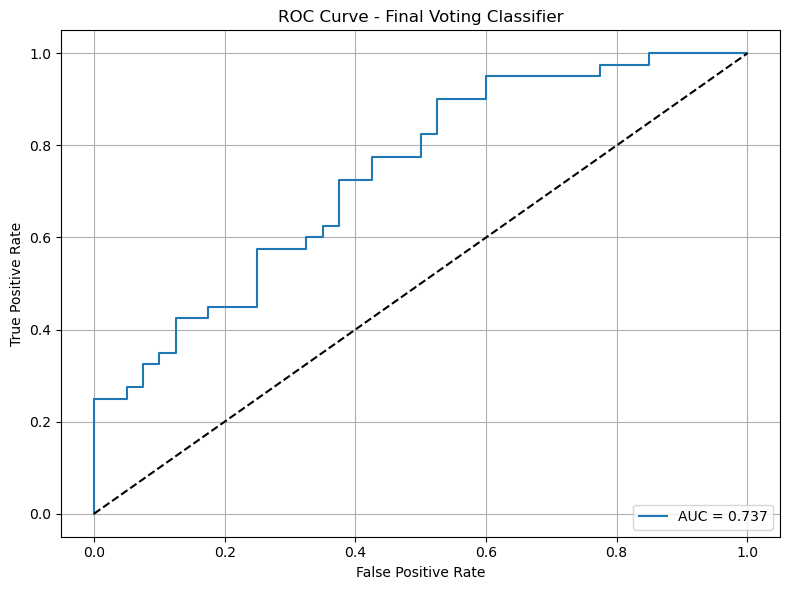

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1
y_probs = best_voting_clf.predict_proba(X_test_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Voting Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [354]:
print(roc_auc_score(y_val, y_pred))

0.7747747747747747


In [355]:
best_lr.score(X_val_selected, y_val)

0.7657657657657657

### Regression model for Point Diff

In [356]:
train.columns

Index(['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff', 'win', 'Diff_AdjT',
       'Diff_Luck', 'Diff_avg_opponent_FGA', 'Diff_MOR',
       'Diff_avg_opponent_FGM3', 'Diff_ORtg', 'Diff_COL', 'Diff_avg_Stl',
       'Diff_avg_FGA3', 'Diff_avg_FGA', 'Diff_avg_Score',
       'Diff_avg_opponent_FGM', 'Diff_avg_opponent_Blk',
       'Diff_avg_opponent_Ast', 'Diff_avg_opponent_PF', 'Diff_avg_FTA',
       'Diff_avg_opponent_FGA3', 'Diff_avg_opponent_FTA',
       'Diff_avg_opponent_FTM', 'Diff_BIH', 'Diff_SchedStrengthNetRtg',
       'Diff_avg_Ast', 'Diff_avg_opponent_Stl', 'Diff_avg_Blk', 'Diff_avg_FGM',
       'Diff_avg_opponent_OR', 'Diff_RPI', 'Diff_NCSOSNetRtg',
       'Diff_avg_opponent_TO', 'Diff_avg_FTM', 'Diff_avg_TO', 'Diff_avg_FGM3',
       'Diff_avg_opponent_DR', 'Diff_avg_OR', 'Diff_avg_PF', 'Diff_avg_DR',
       'Diff_avg_opponent_Score', 'Diff_avg_PointDiff', 'Diff_Drtg',
       'Diff_MAS'],
      dtype='object')

In [357]:
# Full training set, not feature selected 
y_train_pointdiff = train["PointDiff"]
y_train_pointdiff

0        8.0
1       29.0
2       13.0
3        6.0
4        2.0
        ... 
2491   -26.0
2492   -20.0
2493   -16.0
2494    -4.0
2495    -3.0
Name: PointDiff, Length: 2496, dtype: float64

In [358]:
y_val_pointdiff = validation["PointDiff"]
y_val_pointdiff

1248     1
1250    25
1253    10
1254     8
1255    23
        ..
2823   -12
2824    -6
2825   -14
2826   -13
2827   -15
Name: PointDiff, Length: 222, dtype: int64

In [359]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
model = LinearRegression()
model.fit(X_train_selected, y_train_pointdiff, sample_weight=final_weights)
y_pred_lr = model.predict(X_val_selected)
# Generate report 
# Evaluate the model
mse = mean_squared_error(y_val_pointdiff, y_pred_lr)
r2 = r2_score(y_val_pointdiff, y_pred_lr)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 105.46662101905235
R^2 Score: 0.589307316852664


In [360]:

linreg_imp = permutation_importance(model, X_val_selected, y_val_pointdiff, n_repeats=10, random_state=42)

In [361]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# Define the hyperparameter grid
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge = Ridge(alpha=1.0, random_state=42)  # L2 regularization
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

'''
ridge.fit(X_train_selected, y_train_pointdiff,  sample_weight=final_weights)
# Predict on the test set
y_pred_ridge = ridge.predict(X_val_selected)
'''

grid = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='r2')

# Fit using sample weights
grid.fit(X_train_selected, y_train_pointdiff, sample_weight=final_weights)

# Predict and evaluate
best_ridge = grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_val_selected)




mse = mean_squared_error(y_val_pointdiff, y_pred_ridge)
r2 = r2_score(y_val_pointdiff, y_pred_ridge)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 105.46713819288145
R^2 Score: 0.5893053029500144


In [362]:
ridge_imp = permutation_importance(best_ridge, X_val_selected, y_val_pointdiff, n_repeats=10, random_state=42)

In [420]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt']
}


rfr.fit(X_train_selected, y_train_pointdiff,  sample_weight=final_weights)
y_pred_rfr = rfr.predict(X_val_selected)

'''
# Set up GridSearchCV
grid = GridSearchCV(estimator=rfr, param_grid=param_grid, 
                    cv=3, scoring='r2', n_jobs=-1)

# Fit model with sample weights
grid.fit(X_train_selected, y_train_pointdiff, sample_weight=final_weights)

# Predict and evaluate
rfr = grid.best_estimator_
y_pred_rfr = rfr.predict(X_val_selected)
'''
mse = mean_squared_error(y_val_pointdiff, y_pred_rfr)
r2 = r2_score(y_val_pointdiff, y_pred_rfr)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# grid search failed and decreased R^2

Mean Squared Error: 121.04103693693695
R^2 Score: 0.528659705314857


In [364]:
rfr_imp = permutation_importance(rfr, X_val_selected, y_val_pointdiff, n_repeats=10, random_state=42)

In [365]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
} 
'''
gbr.fit(X_train_selected, y_train_pointdiff,  sample_weight=final_weights)
y_pred_gbr = gbr.predict(X_val_selected)
'''

grid = GridSearchCV(estimator=gbr, param_grid=param_grid, 
                    cv=3, scoring='r2', n_jobs=-1)

# Fit with sample weights
grid.fit(X_train_selected, y_train_pointdiff, sample_weight=final_weights)

# Predict and evaluate
best_gbr = grid.best_estimator_
y_pred_gbr = best_gbr.predict(X_val_selected)


mse = mean_squared_error(y_val_pointdiff, y_pred_gbr)
r2 = r2_score(y_val_pointdiff, y_pred_gbr)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 119.58329341492906
R^2 Score: 0.5343362368336388


In [366]:
gbr_imp = permutation_importance(best_gbr, X_val_selected, y_val_pointdiff, n_repeats=10, random_state=42)

In [367]:

n_samples = len(X_train_selected)
indices = np.random.choice(
    np.arange(n_samples),
    size=n_samples,
    replace=True,
    p=final_weights / final_weights.sum()
)
X_weighted = X_train_selected[indices]
y_weighted_pointdiff = y_train_pointdiff[indices]


In [409]:
# no sample weights argument

# K-Neighbors Regressor
knn = KNeighborsRegressor(n_neighbors=5)
'''
knn.fit(X_weighted, y_weighted_pointdiff)
y_pred_knn = knn.predict(X_val_selected)
'''
# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean distance
}

# Setup GridSearchCV
grid = GridSearchCV(knn, param_grid, cv=3, scoring='r2', n_jobs=-1)

# Fit on training data
grid.fit(X_train_selected, y_train_pointdiff)

# Predict on validation set
best_knn = grid.best_estimator_
y_pred_knn = best_knn.predict(X_val_selected)

mse = mean_squared_error(y_val_pointdiff, y_pred_knn)
r2 = r2_score(y_val_pointdiff, y_pred_knn)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 128.78845512178845
R^2 Score: 0.4984908430619709


In [410]:
grid.best_params_

{'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}

In [369]:
knn_imp = permutation_importance(best_knn, X_val_selected, y_val_pointdiff, n_repeats=10, random_state=42)

In [416]:
# Support Vector Regressor
svr = SVR(C=1.0, epsilon=0.2)
'''
svr.fit(X_train_selected, y_train_pointdiff, sample_weight=final_weights)
y_pred_svr = svr.predict(X_val_selected)
'''
param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'degree': [2, 3]  # used only with 'poly' kernel
}

grid = GridSearchCV(svr, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train_selected, y_train_pointdiff)

# Best estimator
best_svr = grid.best_estimator_
y_pred_svr = best_svr.predict(X_val_selected)


mse = mean_squared_error(y_val_pointdiff, y_pred_svr)
r2 = r2_score(y_val_pointdiff, y_pred_svr)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 104.68853485994237
R^2 Score: 0.5923372261198525


In [418]:
grid.best_params_

{'C': 10, 'degree': 2, 'epsilon': 0.1, 'kernel': 'linear'}

In [371]:
svr_imp = permutation_importance(best_svr, X_val_selected, y_val_pointdiff, n_repeats=10, random_state=42)

In [414]:
# Multi-layer Perceptron Regressor
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)

mlp.fit(X_weighted, y_weighted_pointdiff)
y_pred_mlp = mlp.predict(X_val_selected)

mse = mean_squared_error(y_val_pointdiff, y_pred_mlp)
r2 = r2_score(y_val_pointdiff, y_pred_mlp)


print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
# no sample weights argument

# 61.7


Mean Squared Error: 99.85588709740782
R^2 Score: 0.6111558158985346


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [373]:
mlp_imp = permutation_importance(mlp, X_val_selected, y_val_pointdiff, n_repeats=10, random_state=42)
sorted_idx = mlp_imp.importances_mean.argsort()
sorted_idx

array([ 9,  6,  5,  8,  3,  7,  2,  4,  0, 10, 11,  1])

### Feature Importances

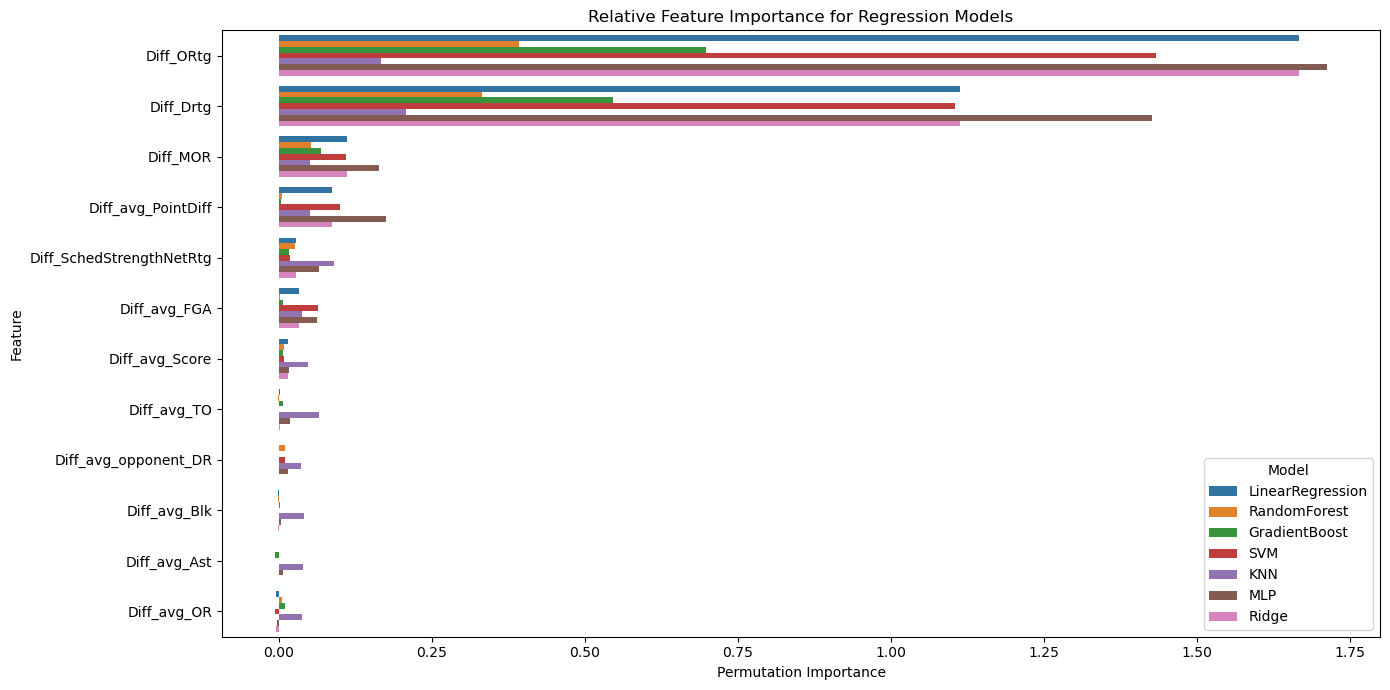

In [374]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Custom order (can be ignored if you want dynamic ranking instead)
custom_order = np.array([ 9, 11,  1,  3,  2,  0,  6,  7,  5, 10,  4,  8])
ordered_feature_names = X_val_selected_df.columns[custom_order]

# Build DataFrame
perm_df = pd.DataFrame({
    'Feature': ordered_feature_names,
    'LinearRegression': linreg_imp.importances_mean[custom_order],
    'RandomForest': rfr_imp.importances_mean[custom_order],
    'GradientBoost': gbr_imp.importances_mean[custom_order],
    'SVM': svr_imp.importances_mean[custom_order],
    'KNN': knn_imp.importances_mean[custom_order],
    'MLP': mlp_imp.importances_mean[custom_order],
    'Ridge': ridge_imp.importances_mean[custom_order]
})

# Compute average importance and select top N
perm_df['Average'] = perm_df.drop(columns='Feature').mean(axis=1)
top_n = 12
top_features = perm_df.sort_values('Average', ascending=False).head(top_n)
top_features = top_features.drop(columns='Average')
# Melt for plotting
melted = top_features.melt(id_vars='Feature', var_name='Model', value_name='Importance')

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(data=melted, x='Importance', y='Feature', hue='Model')
plt.title(f'Relative Feature Importance for Regression Models')
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.show()


NN for regression (continuous prediction) performed best!

In [411]:
r2_scores = {
    "MLP Regressor":  0.6111558158985346, #
    "Gradient Boosting": 0.5343362368336388,  #
    "KNN Regressor": 0.4984908430619709, #
    "SVR": 0.5923372261198525, #
    "Linear Regression": 0.589307316852664, #
    "Ridge Regression": 0.5893053029500144, #
    "Random Forest": 0.528659705314857
}

Could use grid search to optimize if we want

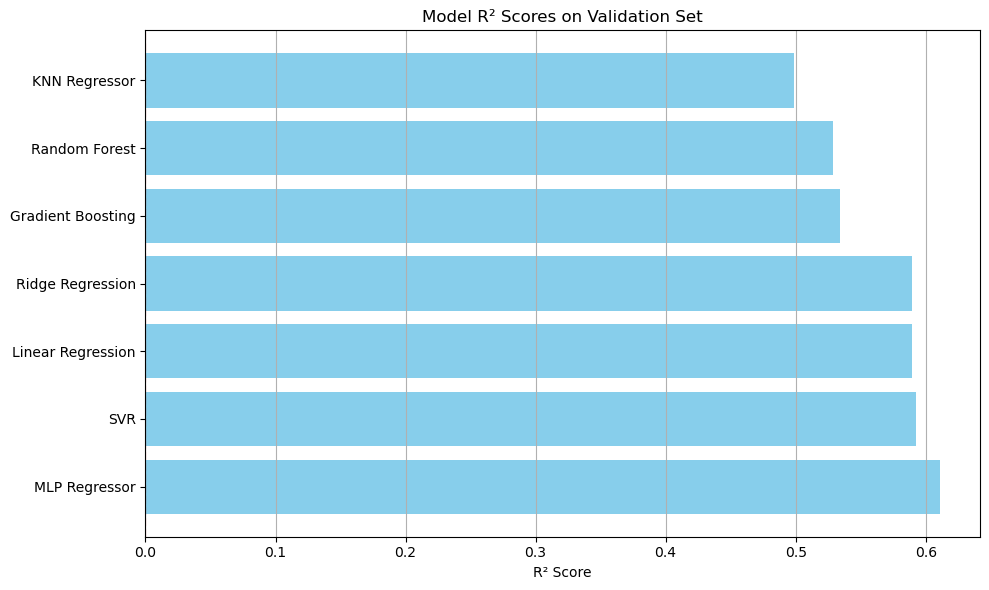

In [412]:
import matplotlib.pyplot as plt

# Sort models by R² for cleaner plotting
sorted_models = sorted(r2_scores.items(), key=lambda x: x[1], reverse=True)

# Separate names and values
model_names = [name for name, _ in sorted_models]
r2_values = [r2 for _, r2 in sorted_models]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(model_names, r2_values, color='skyblue')
plt.xlabel("R² Score")
plt.title("Model R² Scores on Validation Set")
plt.axvline(0, color='red', linestyle='--')  # Useful to see if below 0
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [377]:
from scipy.stats import pearsonr
import pandas as pd
import itertools

def residual_correlations_with_pairs(y_true, model_preds_dict, threshold=None):
    """
    Compute Pearson correlation between residuals of regression models.
    
    Parameters:
    - y_true: Actual target values (array-like)
    - model_preds_dict: Dict with model names as keys and predicted values as values.
    - threshold: If set, only returns pairs with correlation below this value.
    
    Returns:
    - DataFrame with model pairs and residual correlation
    """
    rows = []
    for m1, m2 in itertools.combinations(model_preds_dict, 2):
        r1 = y_true - model_preds_dict[m1]
        r2 = y_true - model_preds_dict[m2]
        corr, _ = pearsonr(r1, r2)
        rows.append({
            'Model 1': m1,
            'Model 2': m2,
            'Residual Correlation': corr
        })
    
    df = pd.DataFrame(rows)
    if threshold is not None:
        df = df[df['Residual Correlation'] < threshold]
    return df.sort_values(by='Residual Correlation')


In [378]:
model_preds = {
    'Ridge': y_pred_ridge,
    'RF': y_pred_rfr,
    'GB': y_pred_gbr,
    'SVR': y_pred_svr,
    'MLP': y_pred_mlp, 
    'KNN': y_pred_knn,
    'Linear Reg': y_pred_lr
}

# Get all residual correlations
all_pairs = residual_correlations_with_pairs(y_val_pointdiff, model_preds)
all_pairs


,Model 1,Model 2,Residual Correlation
18,MLP,KNN,0.900947
13,GB,KNN,0.924182
16,SVR,KNN,0.925299
20,KNN,Linear Reg,0.926785
4,Ridge,KNN,0.926787
12,GB,MLP,0.927054
8,RF,MLP,0.931654
9,RF,KNN,0.943766
11,GB,SVR,0.948291
14,GB,Linear Reg,0.951564


In [379]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

stacking_reg = StackingRegressor(
    estimators=[
        ('lr', model),
        ('ridge', best_ridge),
        ('rf', rfr),
        ('gb', best_gbr),
        ('mlp', mlp), #
        ('svr', best_svr), #
        ('knn', best_knn)
    ],
    final_estimator=MLPRegressor()  # or another regressor
)

stacking_reg.fit(X_train_selected, y_train_pointdiff)
y_pred = stacking_reg.predict(X_val_selected)


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization

In [380]:

# Evaluate
mse = mean_squared_error(y_val_pointdiff, y_pred)
r2 = r2_score(y_val_pointdiff, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# lower than inidvidual R^2

Mean Squared Error: 123.6574268087754
R^2 Score: 0.5184713427197309


## Stacking Heterogenous Model Types

In [461]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

def stack_with_gridsearch(classifier_models, regressor_models, 
                          X_train, y_train, X_val, y_val):
    """
    Build stacked features using training set to fit meta-model,
    and evaluate on separate validation set to avoid overfitting.
    """
    # 1. Train classifiers and get train probs
    train_probs = [clf.predict_proba(X_train)[:, 1] for clf in classifier_models]
    val_probs = [clf.predict_proba(X_val)[:, 1] for clf in classifier_models]

    # 2. Get regressor predictions
    train_reg_preds = [reg.predict(X_train) for reg in regressor_models]
    val_reg_preds = [reg.predict(X_val) for reg in regressor_models]

    # 3. Combine features
    X_meta_train = np.column_stack(train_probs + train_reg_preds)
    X_meta_val = np.column_stack(val_probs + val_reg_preds)

    # 4. Grid search over XGBoost
    meta_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

    grid = GridSearchCV(meta_model, param_grid, cv=5, scoring='accuracy')
    grid.fit(X_meta_train, y_train)

    # 5. Evaluate on validation
    y_pred = grid.predict(X_meta_val)
    y_proba = grid.predict_proba(X_meta_val)[:, 1]  # Probabilities for AUC
    report = classification_report(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    return grid.best_estimator_, grid.best_params_, report, auc


In [462]:
# List of fitted classifier models
#classifier_models = [best_lr, best_clf, best_gb, best_mlp, best_svc, best_gnb]
classifier_models = [best_lr, best_gnb, best_clf, best_mlp, best_gb, best_svc]
# List of fitted regressor models
#regressor_models = [model, ridge, rfr, gbr, svr, mlp, knn]
regressor_models = [model, best_ridge, rfr, best_gbr, best_svr, mlp, best_knn]

# Call the stacking function
meta_model, best_params, report, auc = stack_with_gridsearch(
    classifier_models=classifier_models,
    regressor_models=regressor_models,
    X_train=X_train_selected,
    y_train=y_train,
    X_val=X_val_selected,
    y_val=y_val
)

# Output
print("Best Meta-Learner Params:", best_params)
print("ROC AUC Score:", auc)
print(report)


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:20:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:20:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:20:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:20:11] WARNING: /Users/runner/work/xgboost/xgbo

Best Meta-Learner Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
ROC AUC Score: 0.811257203149095
              precision    recall  f1-score   support

           0       0.67      0.83      0.74       111
           1       0.78      0.59      0.67       111

    accuracy                           0.71       222
   macro avg       0.72      0.71      0.71       222
weighted avg       0.72      0.71      0.71       222



/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:23:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Using best trio of classifiers and best solo best regression model 

In [ ]:
# List of fitted classifier models
classifier_models = [best_gb, best_mlp, best_svc]
#classifier_models = [best_lr, best_gnb, best_clf, best_mlp, best_gb, best_svc]
# List of fitted regressor models
regressor_models = [mlp]
#regressor_models = [model, best_ridge, rfr, best_gbr, best_svr, mlp, best_knn]

# Call the stacking function
meta_model, best_params, report = stack_with_gridsearch(
    classifier_models=classifier_models,
    regressor_models=regressor_models,
    X_train=X_train_selected,
    y_train=y_train,
    X_val=X_val_selected,
    y_val=y_val
)

# Output
print("Best Meta-Learner Params:", best_params)
print("ROC AUC Score:", roc_auc_score(y_val, meta_model.predict_proba(X_val_selected)[:, 1]))
print(report)


/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:33:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:33:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:33:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ellawileman/anaconda3/envs/madness/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:33:48] WARNING: /Users/runner/work/xgboost/xgbo

Best Meta-Learner Params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       111
           1       0.76      0.73      0.75       111

    accuracy                           0.75       222
   macro avg       0.75      0.75      0.75       222
weighted avg       0.75      0.75      0.75       222



In [463]:
print(auc)

0.811257203149095


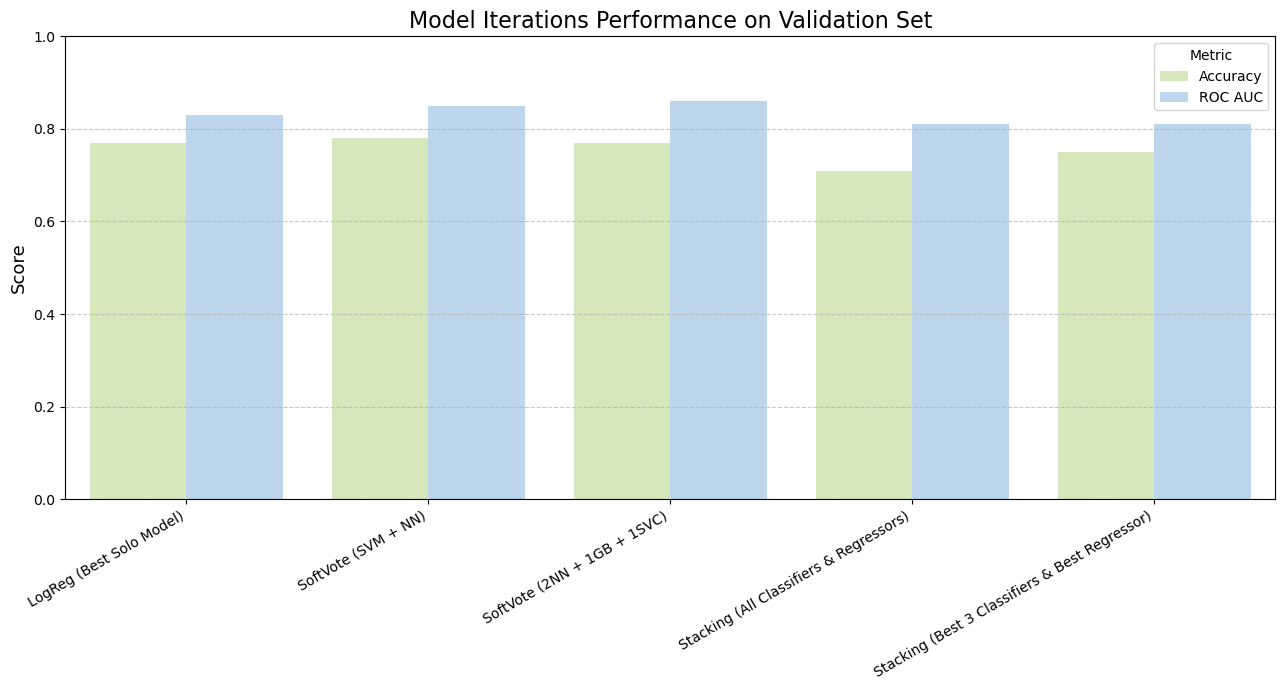

In [479]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import textwrap

# Original labels
model_names = [
    'LogReg (Best Solo Model)',
    'SoftVote (SVM + NN)',
    'SoftVote (2NN + 1GB + 1SVC)',
    'Stacking (All Classifiers & Regressors)',
    'Stacking (Best 3 Classifiers & Best Regressor)'
]

# Wrap labels to max 25 characters per line
wrapped_labels = ['\n'.join(textwrap.wrap(label, 25)) for label in model_names]
accuracies = [0.77, 0.78, 0.77, 0.71, 0.75]
aucs = [0.83, 0.85, 0.86, 0.81, 0.81]

# Create DataFrame
df = pd.DataFrame({
    'Model': model_names * 2,
    'Metric': ['Accuracy'] * len(model_names) + ['ROC AUC'] * len(model_names),
    'Score': accuracies + aucs
})

# Plot
plt.figure(figsize=(13, 7))
custom_palette = ["#d6f0b4", "#b7d7f2"]
sns.barplot(data=df, x='Model', y='Score', hue='Metric', palette=custom_palette)

# Customize
plt.title('Model Iterations Performance on Validation Set', fontsize=16)
plt.ylabel('Score', fontsize=13)
plt.xlabel('', fontsize=20)
plt.xticks(rotation=30, ha='right')
plt.ylim(0.0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric', loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# Grid search
# Define hyperparameter grid
params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}
grid = GridSearchCV(gnb, params, cv=5, scoring='accuracy')
grid.fit(X_train_selected, y_train, sample_weight=final_weights)

# Best model and params
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Params: {'var_smoothing': 1e-09}
Best CV Score: 0.7287615230460922


Best stacking

              precision    recall  f1-score   support

           0       0.62      0.70      0.66        40
           1       0.66      0.57      0.61        40

    accuracy                           0.64        80
   macro avg       0.64      0.64      0.64        80
weighted avg       0.64      0.64      0.64        80

AUC: 0.7321875


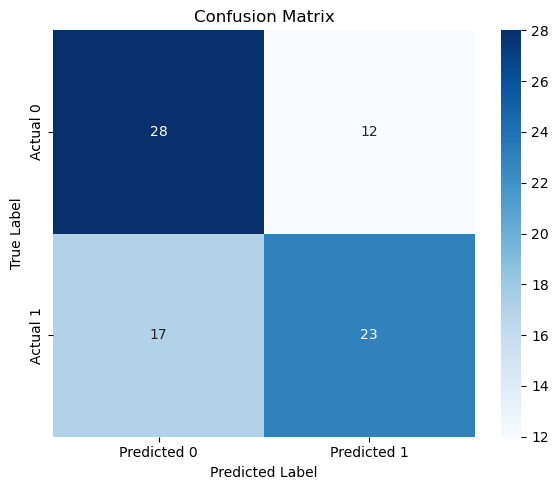

In [394]:
# Generate meta features for test set
test_probs = [clf.predict_proba(X_test_selected)[:, 1] for clf in classifier_models]
test_reg_preds = [reg.predict(X_test_selected) for reg in regressor_models]
X_meta_test = np.column_stack(test_probs + test_reg_preds)

# Predict and evaluate
y_test_pred = meta_model.predict(X_meta_test)
print(classification_report(y_test, y_test_pred))
print("AUC:", roc_auc_score(y_test, meta_model.predict_proba(X_meta_test)[:, 1]))  # ✅ now correct

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [395]:
meta_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)

best stacking 3+ pairs

              precision    recall  f1-score   support

           0       0.66      0.62      0.64        40
           1       0.64      0.68      0.66        40

    accuracy                           0.65        80
   macro avg       0.65      0.65      0.65        80
weighted avg       0.65      0.65      0.65        80

AUC: 0.7368750000000001


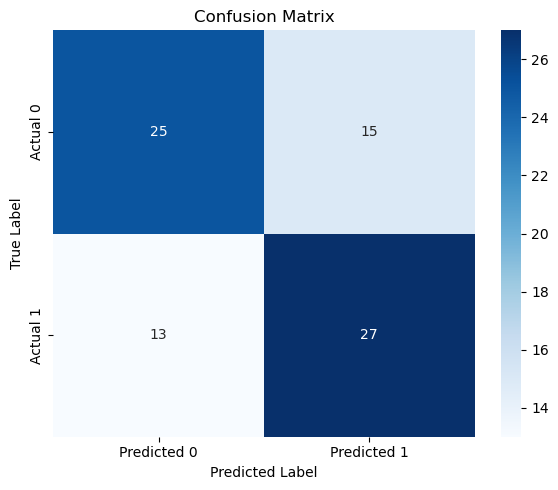

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('nb', GaussianNB()),
                             ('rf', RandomForestClassifier(n_estimators=200)),
                             ('nn',
                              MLPClassifier(max_iter=500, random_state=42)),
                             ('gb', GradientBoostingClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft', weights=[0, 0, 0, 2, 1, 1])

In [396]:


# Predict and evaluate
y_test_pred = best_voting_clf.predict(X_test_selected)
print(classification_report(y_test, y_test_pred))


# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("AUC:", roc_auc_score(y_test, best_voting_clf.predict_proba(X_test_selected)[:, 1]))  # ✅ uses probabilities
# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


best_voting_clf

Best solo learner

              precision    recall  f1-score   support

           0       0.62      0.62      0.62        40
           1       0.62      0.62      0.62        40

    accuracy                           0.62        80
   macro avg       0.62      0.62      0.62        80
weighted avg       0.62      0.62      0.62        80

AUC 0.625


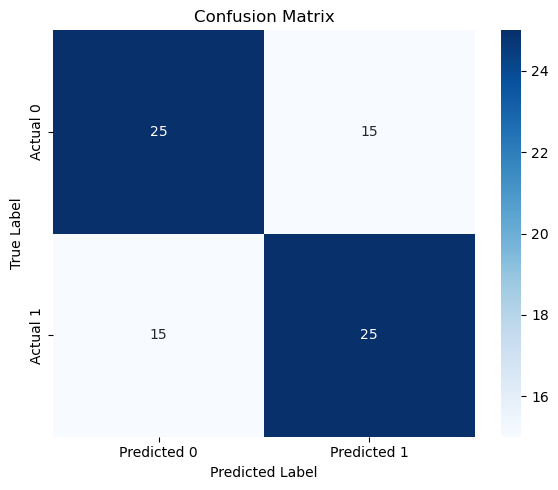

In [ ]:
y_pred_test = best_lr.predict(X_test_selected)
print(classification_report(y_test, y_pred_test))
print("AUC", roc_auc_score(y_test, y_pred_test))    


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

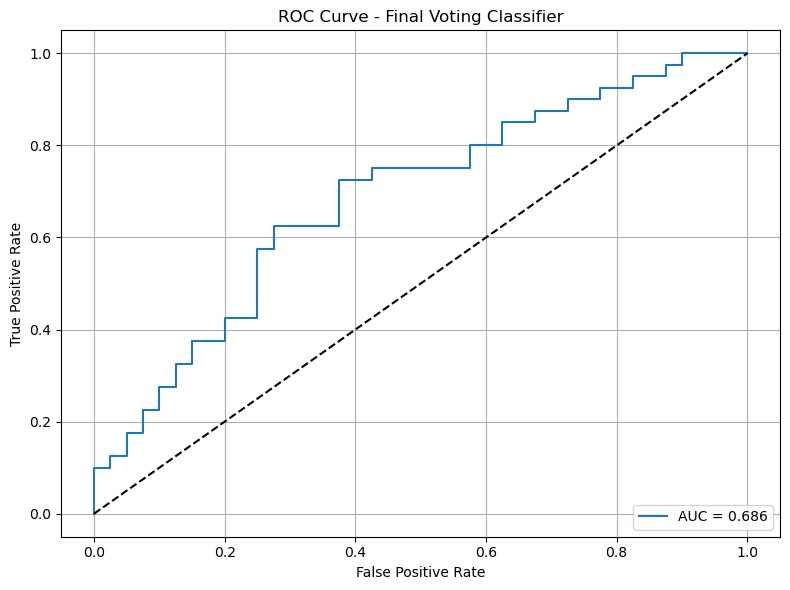

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1
y_probs = best_lr.predict_proba(X_test_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Voting Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
best_lr

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# could show how different iterations of models impact accuracy


Feature Importance (F-score + Coefficient):
                     Feature     F_score  Coefficient
8                  Diff_ORtg  734.823512     1.976607
4                  Diff_Drtg  688.836960    -1.722653
5                   Diff_RPI  622.293008     1.059572
10        Diff_avg_PointDiff  509.662562    -0.702530
6               Diff_avg_FGA   88.797913     0.329213
0               Diff_avg_FGM  195.464689     0.262937
11              Diff_avg_Ast  117.554667    -0.255410
9                Diff_avg_OR   67.115437    -0.177864
3    Diff_avg_opponent_Score   57.675539    -0.161944
2       Diff_avg_opponent_DR   80.088208    -0.157850
7   Diff_SchedStrengthNetRtg  709.842763    -0.091013
1               Diff_avg_Blk  112.954942    -0.052102


/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_77427/3260880508.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


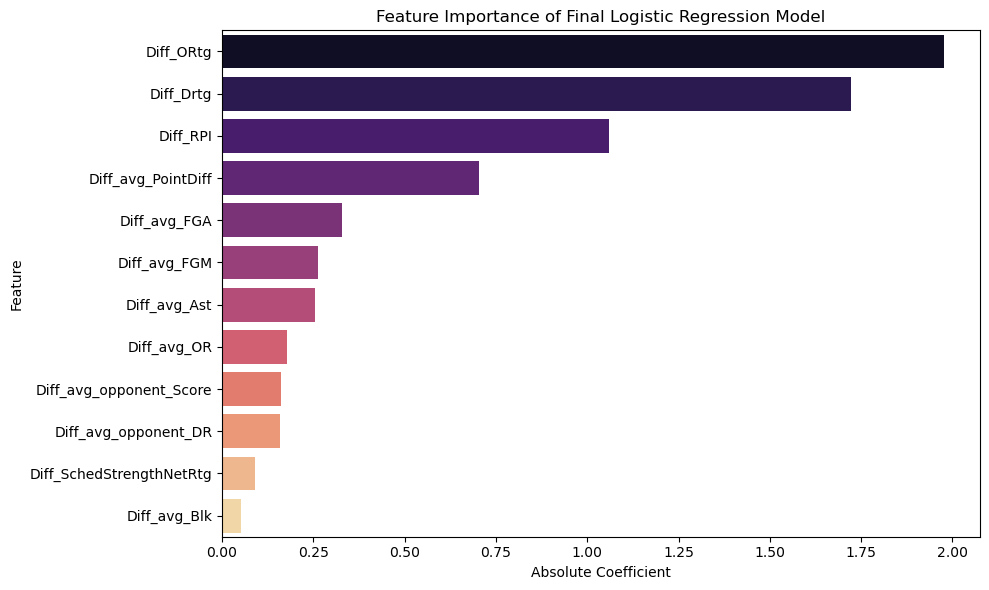

In [ ]:

# 4. Fit model on selected features
#best_lr.fit(X_train_selected, y_train)

# 5. Evaluate on validation set
y_test_pred = best_lr.predict(X_test_selected)
val_acc = accuracy_score(y_test, y_test_pred)

# 6. Inspect the final feature importance
feature_importance_df = pd.DataFrame({
    "Feature": final_selected_features,
    "F_score": selector.scores_[selector.get_support()],
    "Coefficient": best_lr.coef_[0]
})

# Optional: Sort by absolute coefficient importance
feature_importance_df["Abs_Coefficient"] = np.abs(feature_importance_df["Coefficient"])
feature_importance_df = feature_importance_df.sort_values(by="Abs_Coefficient", ascending=False)

print("\nFeature Importance (F-score + Coefficient):")
print(feature_importance_df[["Feature", "F_score", "Coefficient"]])

# 7. Plot bar chart of feature importance by coefficient magnitude
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df,
    y="Feature", x="Abs_Coefficient", palette="magma"
)
plt.title(f"Feature Importance of Final Logistic Regression Model")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


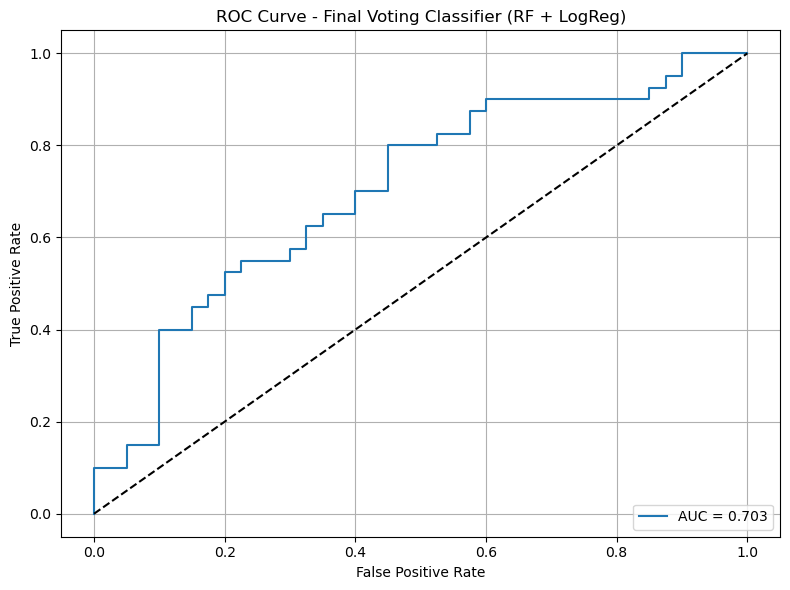

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1
y_probs = lr_rf.predict_proba(X_test_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Voting Classifier (RF + LogReg)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

           0       0.65      0.65      0.65        40
           1       0.65      0.65      0.65        40

    accuracy                           0.65        80
   macro avg       0.65      0.65      0.65        80
weighted avg       0.65      0.65      0.65        80

AUC 0.65


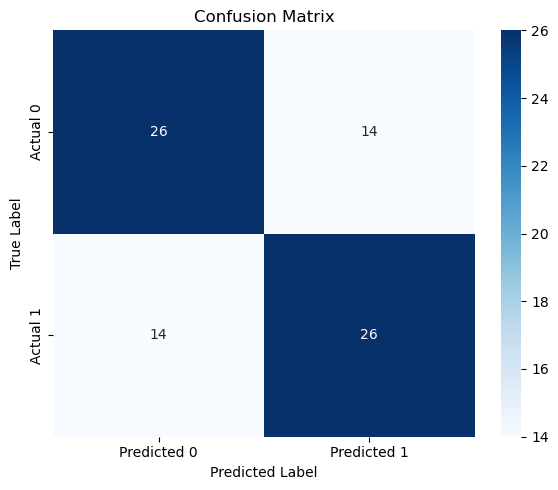

In [ ]:
y_pred_test = lr_rf.predict(X_test_selected)
print(classification_report(y_test, y_pred_test))
print("AUC", roc_auc_score(y_test, y_pred_test))    


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
y_pred_test

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.])

In [ ]:
X_test_selected_df.head()

,Diff_avg_FGM,Diff_avg_Blk,Diff_avg_opponent_DR,Diff_avg_opponent_Score,Diff_Drtg,Diff_RPI,Diff_avg_FGA,Diff_SchedStrengthNetRtg,Diff_ORtg,Diff_avg_OR,Diff_avg_PointDiff,Diff_avg_Ast
0,2.585575,0.251951,-1.136856,0.685616,-1.848090,-2.533801,2.128388,2.982210,3.663129,1.962978,2.556714,1.763180
1,0.224689,1.305750,-1.218513,-3.045679,-3.188307,-3.564796,0.266060,2.513614,2.222712,0.386814,2.354911,-0.407355
2,1.064205,2.104607,-1.265078,-0.451982,-2.906156,-4.351148,0.951833,3.322171,2.781495,1.439582,2.390820,0.963267
3,-0.275048,0.631875,0.793608,-0.349074,-1.580046,-0.297066,0.032498,2.316725,0.086922,-0.179790,-0.532971,0.658464
4,1.031782,0.490998,0.897432,0.701795,-1.086282,-3.267730,-0.149970,2.602871,2.545564,-1.783987,1.014823,0.074022


In [ ]:
test.columns

Index(['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff', 'win', 'Diff_avg_FGM',
       'Diff_avg_Stl', 'Diff_avg_opponent_Blk', 'Diff_avg_opponent_Ast',
       'Diff_avg_opponent_Stl', 'Diff_avg_Blk', 'Diff_avg_DR',
       'Diff_avg_opponent_DR', 'Diff_avg_opponent_Score',
       'Diff_avg_opponent_FGA3', 'Diff_AdjT', 'Diff_avg_opponent_FTA',
       'Diff_avg_FGM3', 'Diff_avg_opponent_PF', 'Diff_avg_opponent_OR',
       'Diff_avg_opponent_FGM', 'Diff_avg_Score', 'Diff_Drtg', 'Diff_RPI',
       'Diff_MOR', 'Diff_avg_opponent_FGA', 'Diff_avg_FGA',
       'Diff_avg_opponent_FGM3', 'Diff_avg_PF', 'Diff_SchedStrengthNetRtg',
       'Diff_avg_TO', 'Diff_avg_FGA3', 'Diff_ORtg', 'Diff_MAS',
       'Diff_avg_opponent_TO', 'Diff_avg_FTA', 'Diff_BIH', 'Diff_avg_FTM',
       'Diff_avg_OR', 'Diff_avg_PointDiff', 'Diff_NCSOSNetRtg', 'Diff_COL',
       'Diff_Luck', 'Diff_avg_opponent_FTM', 'Diff_avg_Ast'],
      dtype='object')

In [ ]:
test[["T1_TeamID", "T2_TeamID"]]

,T1_TeamID,T2_TeamID
1382,1196,1436
1383,1222,1255
1384,1120,1159
1385,1242,1463
1386,1314,1233
1387,1112,1179
1388,1228,1241
1389,1166,1305
1390,1181,1242
1391,1222,1228


In [ ]:
team_matchups = pd.merge(test[["T1_TeamID", "T2_TeamID"]].copy(), teams[["TeamID", "TeamName"]], left_on="T1_TeamID", right_on="TeamID", how="left").rename(columns={"TeamName": "T1_TeamName"})
team_matchups = pd.merge(team_matchups, teams[["TeamID", "TeamName"]], left_on="T2_TeamID", right_on="TeamID", how="left").rename(columns={"TeamName": "T2_TeamName"})
team_matchups

,T1_TeamID,T2_TeamID,TeamID_x,T1_TeamName,TeamID_y,T2_TeamName
0,1196,1436,1196,Florida,1436,Vermont
1,1222,1255,1222,Houston,1255,Longwood
2,1120,1159,1120,Auburn,1159,Colgate
3,1242,1463,1242,Kansas,1463,Yale
4,1314,1233,1314,North Carolina,1233,Iona
...,...,...,...,...,...,...
75,1248,1116,1248,Lafayette,1116,Arkansas
76,1177,1336,1177,DePaul,1336,Penn St
77,1304,1348,1304,Nebraska,1348,Rhode Island
78,1429,1250,1429,Utah St,1250,Lehigh


In [ ]:
team_combos = team_matchups[["T1_TeamName", "T2_TeamName"]]
team_combos

,T1_TeamName,T2_TeamName
0,Florida,Vermont
1,Houston,Longwood
2,Auburn,Colgate
3,Kansas,Yale
4,North Carolina,Iona
...,...,...
75,Lafayette,Arkansas
76,DePaul,Penn St
77,Nebraska,Rhode Island
78,Utah St,Lehigh


In [ ]:
y_pred_test_df = pd.DataFrame(y_pred_test)

In [ ]:
predicted_winners = pd.concat([team_combos.reset_index(drop=True),
                         y_pred_test_df.reset_index(drop=True)], axis=1)
predicted_winners = predicted_winners.rename(columns={0: 'Team 1 Outcome'})
predicted_winners


,T1_TeamName,T2_TeamName,PredictedWinner
0,Florida,Vermont,1.0
1,Houston,Longwood,1.0
2,Auburn,Colgate,1.0
3,Kansas,Yale,1.0
4,North Carolina,Iona,1.0
...,...,...,...
75,Lafayette,Arkansas,0.0
76,DePaul,Penn St,0.0
77,Nebraska,Rhode Island,1.0
78,Utah St,Lehigh,1.0


In [ ]:
predicted_winners.to_csv("predicted_winners.csv", index = False) 

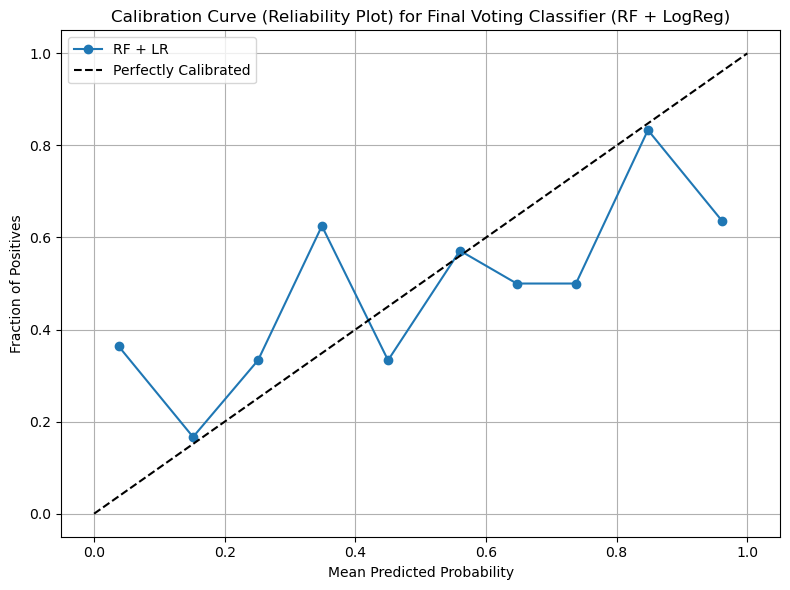

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities for class 1
y_probs = lr_rf.predict_proba(X_test_selected)[:, 1]

# Compute calibration curve (fraction of positives vs predicted probs)
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10, strategy='uniform')

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='RF + LogReg')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')  # Diagonal reference
plt.title('Calibration Curve (Reliability Plot) for Final Voting Classifier (RF + LogReg)')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
